In [1]:
# Modelo de Propension de Compra

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#importamos librería

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import xgboost as xgb # gradient boosting decision tree

from sklearn.ensemble import RandomForestClassifier

from sklearn import model_selection

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import export_graphviz
import graphviz

import pickle








/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


### Data Preparation

In [4]:
df_cust_demo =pd.read_csv("/kaggle/input/df-cust-demo/df_cust_demo.csv")

In [5]:
df_cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5929961 entries, 0 to 5929960
Data columns (total 25 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   entry_date          object 
 3   entry_channel       int64  
 4   active_customer     int64  
 5   segment             int64  
 6   short_term_deposit  int64  
 7   loans               int64  
 8   mortgage            int64  
 9   funds               int64  
 10  securities          int64  
 11  long_term_deposit   int64  
 12  credit_card         int64  
 13  payroll             int64  
 14  pension_plan        int64  
 15  payroll_account     int64  
 16  emc_account         int64  
 17  debit_card          int64  
 18  em_account_p        int64  
 19  em_acount           int64  
 20  country_id          int64  
 21  region_code         int64  
 22  gender              int64  
 23  age                 int64  
 24  salary              floa

In [6]:
# nos facilita la visualizacion del dataframe completo
pd.set_option('display.max_columns', None)

In [7]:
df_cust_demo.shape

(5929961, 25)

In [8]:
df_cust_demo['pk_partition']

0          2018-01
1          2018-01
2          2018-01
3          2018-01
4          2018-01
            ...   
5929956    2019-05
5929957    2019-05
5929958    2019-05
5929959    2019-05
5929960    2019-05
Name: pk_partition, Length: 5929961, dtype: object

In [9]:
df_cust_demo['entry_date']

0          2018-01
1          2015-08
2          2015-08
3          2015-08
4          2015-08
            ...   
5929956    2016-08
5929957    2016-08
5929958    2016-08
5929959    2016-08
5929960    2019-05
Name: entry_date, Length: 5929961, dtype: object

In [10]:
# Hacemos un cast to_datetime de la variable 'month_sale'
df_cust_demo['entry_date'] = pd.to_datetime(df_cust_demo['entry_date'])
df_cust_demo['pk_partition'] = pd.to_datetime(df_cust_demo['pk_partition'])

In [11]:
df_cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5929961 entries, 0 to 5929960
Data columns (total 25 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pk_cid              int64         
 1   pk_partition        datetime64[ns]
 2   entry_date          datetime64[ns]
 3   entry_channel       int64         
 4   active_customer     int64         
 5   segment             int64         
 6   short_term_deposit  int64         
 7   loans               int64         
 8   mortgage            int64         
 9   funds               int64         
 10  securities          int64         
 11  long_term_deposit   int64         
 12  credit_card         int64         
 13  payroll             int64         
 14  pension_plan        int64         
 15  payroll_account     int64         
 16  emc_account         int64         
 17  debit_card          int64         
 18  em_account_p        int64         
 19  em_acount           int64         
 20  co

In [12]:
df_cust_demo.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary
0,1375586,2018-01-01,2018-01-01,60,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,29,1,35,87218.10
1,1050611,2018-01-01,2015-08-01,57,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,13,0,23,35548.74
2,1050612,2018-01-01,2015-08-01,57,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,13,0,23,122179.11
3,1050613,2018-01-01,2015-08-01,56,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50,1,22,119775.54
4,1050614,2018-01-01,2015-08-01,57,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,50,0,23,100737.51


In [13]:
#Extraemos para situarnos los valores de pk_partition
df_cust_demo['pk_partition'].value_counts()

pk_partition
2019-05-01    440572
2019-04-01    437235
2019-03-01    433840
2019-02-01    429424
2019-01-01    424638
2018-12-01    420302
2018-11-01    414308
2018-10-01    400271
2018-09-01    373328
2018-08-01    350981
2018-07-01    337428
2018-06-01    250488
2018-05-01    248333
2018-04-01    245922
2018-03-01    243763
2018-02-01    241063
2018-01-01    238065
Name: count, dtype: int64

In [14]:
df_cust_demo['pk_partition'].nunique()

17

### Funciones / procedimientos

In [15]:
#transform_datetime_column,
#Parametros de entrada

#df --> dataframe
#column_name --> variable dataset (indica fecha)
#Objetivo: convertir en to_datetime la columna que le pasamos como parametro, dividiendo en year, month, dos columnas adicionales
#Nota: en este dataset al tener todas las fechas dia 1 no creara columna adicional 'day_'


In [16]:
def transform_datetime_column(df, column_name):
    # Convertir la columna al formato datetime
    df[column_name] = pd.to_datetime(df[column_name])
    # Crear nuevas columnas de 'año' y 'mes'
    df[f'{column_name}_year'] = df[column_name].dt.year
    df[f'{column_name}_month'] = df[column_name].dt.month
    # Comprobar si el dataset original contiene información sobre el día
    if df[column_name].dt.day.nunique() > 1:
        df[f'{column_name}_day'] = df[column_name].dt.day
    # Eliminar la columna datetime original
    df.drop(column_name, axis=1, inplace=True)
    return df

In [17]:
# COPIAREMOS PARA HACERLO MAS ADELANTE
# Aplicamos la funcion para 'pk_partition' en df_activity_desc_ML
#df_cust_demo1 = transform_datetime_column(df_cust_demo,'pk_partition')

#df_cust_demo1 = transform_datetime_column(df_cust_demo,'entry_date')

In [18]:
##Funcion CreacionVariablesProductos ,los parametros de entrada serian un df y una lista
#Inicializa columnas y en base a una lista_productos hace el sumatorio
# def CreacionVariablesProductos(df,lista_productos)
def CreacionVariablesProductos(df,lista_productos):
  for new_col in set(lista_productos.values()):
      df[new_col] = 0

# Summing the values in the new columns based on the 'tipo_productos' mapping
  for orig_col, new_col in lista_productos.items():
      df[new_col] += df[orig_col]

  return df

In [19]:
df_cust_demo1 = df_cust_demo.copy()

In [20]:
df_cust_demo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5929961 entries, 0 to 5929960
Data columns (total 25 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pk_cid              int64         
 1   pk_partition        datetime64[ns]
 2   entry_date          datetime64[ns]
 3   entry_channel       int64         
 4   active_customer     int64         
 5   segment             int64         
 6   short_term_deposit  int64         
 7   loans               int64         
 8   mortgage            int64         
 9   funds               int64         
 10  securities          int64         
 11  long_term_deposit   int64         
 12  credit_card         int64         
 13  payroll             int64         
 14  pension_plan        int64         
 15  payroll_account     int64         
 16  emc_account         int64         
 17  debit_card          int64         
 18  em_account_p        int64         
 19  em_acount           int64         
 20  co

In [21]:
df_cust_demo1.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary
0,1375586,2018-01-01,2018-01-01,60,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,29,1,35,87218.10
1,1050611,2018-01-01,2015-08-01,57,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,13,0,23,35548.74
2,1050612,2018-01-01,2015-08-01,57,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,13,0,23,122179.11
3,1050613,2018-01-01,2015-08-01,56,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50,1,22,119775.54
4,1050614,2018-01-01,2015-08-01,57,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,50,0,23,100737.51


In [22]:
df_cust_demo1['payroll'].value_counts()

payroll
0    5724195
1     205766
Name: count, dtype: int64

In [23]:
df_cust_demo1['payroll_account'].value_counts()

payroll_account
0    5600684
1     329277
Name: count, dtype: int64

### Definicion de Variables 'listado_productos' / 'tipo_productos'

In [24]:
listado_productos = [col for col in df_cust_demo1.columns if col not in ['pk_cid', 'entry_channel', 'active_customer', 'segment','region_code',
 'gender',
 'age',
 'salary',
 'pk_partition',
 'entry_date'
,'country_id']]

In [25]:
listado_productos

['short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [26]:
tipo_productos = {"short_term_deposit": "activos_financieros" ,"loans": "creditos_prestamos" , "mortgage":"creditos_prestamos" ,"funds":"activos_financieros" ,"securities":"activos_financieros" ,"long_term_deposit": "activos_financieros","credit_card":"creditos_prestamos"  ,'payroll':"cuenta_operaciones",'payroll_account':"cuenta_operaciones" ,"pension_plan":"activos_financieros" ,"emc_account":"cuenta_operaciones" ,"debit_card":"creditos_prestamos" ,"em_account_p":"cuenta_operaciones" ,"em_acount":"cuenta_operaciones"}

In [27]:
tipo_productos

{'short_term_deposit': 'activos_financieros',
 'loans': 'creditos_prestamos',
 'mortgage': 'creditos_prestamos',
 'funds': 'activos_financieros',
 'securities': 'activos_financieros',
 'long_term_deposit': 'activos_financieros',
 'credit_card': 'creditos_prestamos',
 'payroll': 'cuenta_operaciones',
 'payroll_account': 'cuenta_operaciones',
 'pension_plan': 'activos_financieros',
 'emc_account': 'cuenta_operaciones',
 'debit_card': 'creditos_prestamos',
 'em_account_p': 'cuenta_operaciones',
 'em_acount': 'cuenta_operaciones'}

In [28]:
df_cust_demo1.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary
0,1375586,2018-01-01,2018-01-01,60,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,29,1,35,87218.10
1,1050611,2018-01-01,2015-08-01,57,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,13,0,23,35548.74
2,1050612,2018-01-01,2015-08-01,57,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,13,0,23,122179.11
3,1050613,2018-01-01,2015-08-01,56,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50,1,22,119775.54
4,1050614,2018-01-01,2015-08-01,57,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,50,0,23,100737.51


In [29]:
#Analisis del atributo 'entry_date'. y el valor unique
grouped_by_cid = df_cust_demo1.groupby('pk_cid')['entry_date'].agg(list).reset_index()

In [30]:
grouped_by_cid.head(100)

,pk_cid,entry_date
0,15891,"[2018-07-01 00:00:00, 2018-07-01 00:00:00]"
1,16063,"[2018-11-01 00:00:00, 2018-11-01 00:00:00, 201..."
2,16203,"[2018-12-01 00:00:00, 2018-12-01 00:00:00, 201..."
3,16502,"[2018-09-01 00:00:00, 2018-09-01 00:00:00, 201..."
4,17457,"[2017-09-01 00:00:00, 2017-09-01 00:00:00, 201..."
...,...,...
95,40698,"[2017-06-01 00:00:00, 2017-06-01 00:00:00, 201..."
96,40896,"[2015-07-01 00:00:00, 2015-07-01 00:00:00, 201..."
97,41264,"[2019-03-01 00:00:00, 2019-03-01 00:00:00, 201..."
98,41467,"[2018-08-01 00:00:00, 2018-08-01 00:00:00, 201..."


In [31]:
#Agrupacion por pk_cid con el objetivo de visualizar entry_date por pk_cid
unique_entry_dates = df_cust_demo1.groupby('pk_cid')['entry_date'].nunique().reset_index()
unique_entry_dates.columns = ['pk_cid', 'num_unique_entry_dates']
unique_entry_dates

,pk_cid,num_unique_entry_dates
0,15891,1
1,16063,1
2,16203,1
3,16502,1
4,17457,1
...,...,...
453939,1553685,1
453940,1553686,1
453941,1553687,1
453942,1553688,1


In [32]:
# Ordenar el DataFrame por 'pk_cid' y 'pk_partition'
df_cust_demo1.sort_values(['pk_cid', 'pk_partition'], inplace=True)





In [33]:
# Inicializar nuevas columnas para indicadores de compra
for product in listado_productos:
    df_cust_demo1[f'purchased_{product}'] = 0


In [34]:
df_cust_demo1.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary,purchased_short_term_deposit,purchased_loans,purchased_mortgage,purchased_funds,purchased_securities,purchased_long_term_deposit,purchased_credit_card,purchased_payroll,purchased_pension_plan,purchased_payroll_account,purchased_emc_account,purchased_debit_card,purchased_em_account_p,purchased_em_acount
1470425,15891,2018-07-01,2018-07-01,17,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,28,1,59,138422.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2155142,15891,2018-08-01,2018-07-01,17,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,59,138422.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2945940,16063,2018-11-01,2018-11-01,17,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3607695,16063,2018-12-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4005944,16063,2019-01-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
listado_productos

['short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

### Tratamiento del Dataset y Analisis Estadistico

#### Calculo del numero total por productos por pk_cid y pk_partition

In [36]:
# Lista de columnas de productos que quieres sumar
listado_productos = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
                     'long_term_deposit', 'credit_card', 'payroll', 'pension_plan',
                     'payroll_account', 'emc_account', 'debit_card', 'em_account_p',
                     'em_acount']
# Calcular el total de productos sumando las columnas de productos
df_cust_demo1['total_products'] = df_cust_demo1[listado_productos].sum(axis=1)
# Mostrar las primeras filas del DataFrame modificado
df_cust_demo1.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary,purchased_short_term_deposit,purchased_loans,purchased_mortgage,purchased_funds,purchased_securities,purchased_long_term_deposit,purchased_credit_card,purchased_payroll,purchased_pension_plan,purchased_payroll_account,purchased_emc_account,purchased_debit_card,purchased_em_account_p,purchased_em_acount,total_products
1470425,15891,2018-07-01,2018-07-01,17,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,28,1,59,138422.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2155142,15891,2018-08-01,2018-07-01,17,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,59,138422.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2945940,16063,2018-11-01,2018-11-01,17,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3607695,16063,2018-12-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4005944,16063,2019-01-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# Calcular las columnas 'purchased_[product]'
for product in listado_productos:
    # Usar diff() para encontrar cambios entre cada fila y su predecesora
    # Llenar los valores NaN con 0 porque diff() introducirá NaNs
    df_cust_demo1[f'purchased_{product}'] = df_cust_demo1.groupby(['pk_cid'])[product].diff().fillna(0)
    # Un cambio positivo (de 0 a 1) se marca como una compra
    df_cust_demo1[f'purchased_{product}'] = (df_cust_demo1[f'purchased_{product}'] > 0).astype(int)

In [38]:
# Calcular las columnas 'bajas_[product]'
for product in listado_productos:
    # Usar diff() para encontrar cambios entre cada fila y su predecesora
    # Llenar los valores NaN con 0 porque diff() introducirá NaNs
    df_cust_demo1[f'bajas_{product}'] = df_cust_demo1.groupby(['pk_cid'])[product].diff().fillna(0)
    # Un cambio positivo (de 0 a 1) se marca como una compra
    df_cust_demo1[f'bajas_{product}'] = (df_cust_demo1[f'bajas_{product}'] < 0).astype(int)

In [39]:
for product in listado_productos:
    print(f"Valores únicos en la columna 'bajas_{product}': {df_cust_demo1[f'bajas_{product}'].unique()}")

Valores únicos en la columna 'bajas_short_term_deposit': [0 1]
Valores únicos en la columna 'bajas_loans': [0 1]
Valores únicos en la columna 'bajas_mortgage': [0 1]
Valores únicos en la columna 'bajas_funds': [0 1]
Valores únicos en la columna 'bajas_securities': [0 1]
Valores únicos en la columna 'bajas_long_term_deposit': [0 1]
Valores únicos en la columna 'bajas_credit_card': [0 1]
Valores únicos en la columna 'bajas_payroll': [0 1]
Valores únicos en la columna 'bajas_pension_plan': [0 1]
Valores únicos en la columna 'bajas_payroll_account': [0 1]
Valores únicos en la columna 'bajas_emc_account': [0 1]
Valores únicos en la columna 'bajas_debit_card': [0 1]
Valores únicos en la columna 'bajas_em_account_p': [0]
Valores únicos en la columna 'bajas_em_acount': [0 1]


In [40]:
for product in listado_productos:
    print(f"Valores únicos en la columna 'purchased_{product}': {df_cust_demo1[f'purchased_{product}'].unique()}")

Valores únicos en la columna 'purchased_short_term_deposit': [0 1]
Valores únicos en la columna 'purchased_loans': [0 1]
Valores únicos en la columna 'purchased_mortgage': [0 1]
Valores únicos en la columna 'purchased_funds': [0 1]
Valores únicos en la columna 'purchased_securities': [0 1]
Valores únicos en la columna 'purchased_long_term_deposit': [0 1]
Valores únicos en la columna 'purchased_credit_card': [0 1]
Valores únicos en la columna 'purchased_payroll': [0 1]
Valores únicos en la columna 'purchased_pension_plan': [0 1]
Valores únicos en la columna 'purchased_payroll_account': [0 1]
Valores únicos en la columna 'purchased_emc_account': [0 1]
Valores únicos en la columna 'purchased_debit_card': [0 1]
Valores únicos en la columna 'purchased_em_account_p': [0]
Valores únicos en la columna 'purchased_em_acount': [0 1]


In [41]:
df_cust_demo1.head().T

,1470425,2155142,2945940,3607695,4005944
pk_cid,15891,15891,16063,16063,16063
pk_partition,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00
entry_date,2018-07-01 00:00:00,2018-07-01 00:00:00,2018-11-01 00:00:00,2018-11-01 00:00:00,2018-11-01 00:00:00
entry_channel,17,17,17,17,17
active_customer,1,0,1,1,1
segment,-1,2,-1,2,2
short_term_deposit,0,0,0,0,0
loans,0,0,0,0,0
mortgage,0,0,0,0,0
funds,0,0,0,0,0


In [42]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas para las columnas 'purchased_[product]':")
print(df_cust_demo1[[f'purchased_{product}' for product in listado_productos]].describe())


Estadísticas descriptivas para las columnas 'purchased_[product]':
       purchased_short_term_deposit  purchased_loans  purchased_mortgage  \
count                  5.929961e+06     5.929961e+06        5.929961e+06   
mean                   4.322119e-04     3.878609e-06        1.686352e-06   
std                    2.078522e-02     1.969415e-03        1.298595e-03   
min                    0.000000e+00     0.000000e+00        0.000000e+00   
25%                    0.000000e+00     0.000000e+00        0.000000e+00   
50%                    0.000000e+00     0.000000e+00        0.000000e+00   
75%                    0.000000e+00     0.000000e+00        0.000000e+00   
max                    1.000000e+00     1.000000e+00        1.000000e+00   

       purchased_funds  purchased_securities  purchased_long_term_deposit  \
count     5.929961e+06          5.929961e+06                 5.929961e+06   
mean      1.502539e-04          2.118058e-04                 6.740348e-04   
std       1.2256

In [43]:
df_cust_demo1[df_cust_demo1['pk_cid']==1050612].T

,2,469757,688931,963639,975522,1249538,1571735,2037438,2317227,2657869,3316118,3397408,4139210,4522406,5051009,5240312,5742443
pk_cid,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612,1050612
pk_partition,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00
entry_date,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00,2015-08-01 00:00:00
entry_channel,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57
active_customer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
segment,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
short_term_deposit,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
loans,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mortgage,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
funds,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
df_cust_demo1[df_cust_demo1['purchased_securities']==1 ]

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary,purchased_short_term_deposit,purchased_loans,purchased_mortgage,purchased_funds,purchased_securities,purchased_long_term_deposit,purchased_credit_card,purchased_payroll,purchased_pension_plan,purchased_payroll_account,purchased_emc_account,purchased_debit_card,purchased_em_account_p,purchased_em_acount,total_products,bajas_short_term_deposit,bajas_loans,bajas_mortgage,bajas_funds,bajas_securities,bajas_long_term_deposit,bajas_credit_card,bajas_payroll,bajas_pension_plan,bajas_payroll_account,bajas_emc_account,bajas_debit_card,bajas_em_account_p,bajas_em_acount
4455854,17970,2019-02-01,2015-04-01,17,1,2,0,0,0,0,1,0,0,0,1,1,1,1,0,0,1,28,0,75,125301.84,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4849128,26018,2019-03-01,2017-09-01,17,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,28,1,77,121777.62,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4455785,39008,2019-02-01,2019-01-01,61,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,28,1,53,128881.83,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4849387,85843,2019-03-01,2019-02-01,17,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,28,1,77,119142.42,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3817912,87067,2019-01-01,2017-03-01,17,1,2,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,28,0,48,192212.07,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641059,1542723,2019-05-01,2019-03-01,61,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,28,0,72,136438.65,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5641439,1543771,2019-05-01,2019-04-01,61,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,17,0,38,85969.23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5651564,1544736,2019-05-01,2019-04-01,62,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3,1,28,61371.21,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5650267,1545426,2019-05-01,2019-04-01,62,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,8,0,40,110360.73,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
df_cust_demo1[df_cust_demo1['pk_cid']==85843 ].T

,4455910,4849387,5104462,5493070
pk_cid,85843,85843,85843,85843
pk_partition,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00
entry_date,2019-02-01 00:00:00,2019-02-01 00:00:00,2019-02-01 00:00:00,2019-02-01 00:00:00
entry_channel,17,17,17,17
active_customer,0,1,1,1
segment,-1,2,2,2
short_term_deposit,0,0,0,0
loans,0,0,0,0
mortgage,0,0,0,0
funds,0,0,0,0


#### Numero de compras por producto

In [46]:
listado_productos

['short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [47]:
tipo_productos

{'short_term_deposit': 'activos_financieros',
 'loans': 'creditos_prestamos',
 'mortgage': 'creditos_prestamos',
 'funds': 'activos_financieros',
 'securities': 'activos_financieros',
 'long_term_deposit': 'activos_financieros',
 'credit_card': 'creditos_prestamos',
 'payroll': 'cuenta_operaciones',
 'payroll_account': 'cuenta_operaciones',
 'pension_plan': 'activos_financieros',
 'emc_account': 'cuenta_operaciones',
 'debit_card': 'creditos_prestamos',
 'em_account_p': 'cuenta_operaciones',
 'em_acount': 'cuenta_operaciones'}

In [48]:
# Contar el número de compras para cada producto
print("Número de compras para cada producto:")
for product in listado_productos:
    total_compras = df_cust_demo1[f'purchased_{product}'].sum()
    print(f"{product}: {total_compras}")




Número de compras para cada producto:
short_term_deposit: 2563
loans: 23
mortgage: 10
funds: 891
securities: 1256
long_term_deposit: 3997
credit_card: 11009
payroll: 34174
pension_plan: 36815
payroll_account: 21514
emc_account: 14267
debit_card: 73028
em_account_p: 0
em_acount: 40900


In [49]:
# Contar el número total de compras (suma de todas las compras de productos)
total_compras_general = df_cust_demo1[[f'purchased_{product}' for product in listado_productos]].sum().sum()
print(f"\nNúmero total de compras: {total_compras_general}")


Número total de compras: 240447


#### Numero de bajas por producto

In [50]:
# Contar el número de bajas para cada producto
print("Número de compras para cada producto:")
for product in listado_productos:
    total_bajas = df_cust_demo1[f'bajas_{product}'].sum()
    print(f"{product}: {total_bajas}")


Número de compras para cada producto:
short_term_deposit: 5336
loans: 14
mortgage: 2
funds: 387
securities: 452
long_term_deposit: 3373
credit_card: 9679
payroll: 26783
pension_plan: 29116
payroll_account: 9350
emc_account: 4975
debit_card: 55486
em_account_p: 0
em_acount: 50873


In [51]:
# Contar el número total de compras (suma de todas las compras de productos)
total_bajas_general = df_cust_demo1[[f'bajas_{product}' for product in listado_productos]].sum().sum()
print(f"\nNúmero total de bajas: {total_bajas_general}")


Número total de bajas: 195826


In [52]:
# Calcular el número total de registros en el DataFrame
total_registros = len(df_cust_demo1)
# Calcular el porcentaje de bajas para cada producto


print("Porcentaje de compras para cada producto:")
for product in listado_productos:
    total_bajas = df_cust_demo1[f'bajas_{product}'].sum()
    porcentaje_bajas = (total_bajas / total_registros) * 100

    print(f"{product}: {porcentaje_bajas:.2f}%")

Porcentaje de compras para cada producto:
short_term_deposit: 0.09%
loans: 0.00%
mortgage: 0.00%
funds: 0.01%
securities: 0.01%
long_term_deposit: 0.06%
credit_card: 0.16%
payroll: 0.45%
pension_plan: 0.49%
payroll_account: 0.16%
emc_account: 0.08%
debit_card: 0.94%
em_account_p: 0.00%
em_acount: 0.86%


#### Compras Vs Sales (dataset sales)

In [53]:
#Las compras anteriormente detalladas serian 240447 y el dataset de sales tiene un total de registro de 240773. Lo que nos lleva a la conclusion que estamos en
#buena direccion en el tratamiento de los datasets, ya que las altas (compras de los clientes) coincide con las ventas del banco.



In [54]:
# Contar el número de compras para cada producto por cada 'pk_partition'
print("\nNúmero de compras para cada producto por cada 'pk_partition':")
compras_por_partition_producto = df_cust_demo1.groupby('pk_partition')[[f'purchased_{product}' for product in listado_productos]].sum()
print(compras_por_partition_producto)


Número de compras para cada producto por cada 'pk_partition':
              purchased_short_term_deposit  purchased_loans  \
pk_partition                                                  
2018-01-01                               0                0   
2018-02-01                             264                0   
2018-03-01                             398                4   
2018-04-01                             227                2   
2018-05-01                             209                3   
2018-06-01                             245                0   
2018-07-01                             226                1   
2018-08-01                             267                2   
2018-09-01                             329                2   
2018-10-01                             300                2   
2018-11-01                              92                0   
2018-12-01                               6                1   
2019-01-01                               0             

In [55]:
# Contar el número total de compras por cada 'pk_partition'
print("\nNúmero total de compras por cada 'pk_partition':")
compras_totales_por_partition = compras_por_partition_producto.sum(axis=1)
print(compras_totales_por_partition)


Número total de compras por cada 'pk_partition':
pk_partition
2018-01-01        0
2018-02-01    11157
2018-03-01    11586
2018-04-01    10580
2018-05-01    10435
2018-06-01    14527
2018-07-01    13252
2018-08-01    14397
2018-09-01    15383
2018-10-01    18603
2018-11-01    16825
2018-12-01    19646
2019-01-01    13988
2019-02-01    20848
2019-03-01    16789
2019-04-01    15439
2019-05-01    16992
dtype: int64


In [56]:
# Calcular el número total de registros en el DataFrame
total_registros = len(df_cust_demo1)
# Calcular el porcentaje de compras para cada producto


print("Porcentaje de compras para cada producto:")
for product in listado_productos:
    total_compras = df_cust_demo1[f'purchased_{product}'].sum()
    porcentaje_compras = (total_compras / total_registros) * 100

    print(f"{product}: {porcentaje_compras:.2f}%")

Porcentaje de compras para cada producto:
short_term_deposit: 0.04%
loans: 0.00%
mortgage: 0.00%
funds: 0.02%
securities: 0.02%
long_term_deposit: 0.07%
credit_card: 0.19%
payroll: 0.58%
pension_plan: 0.62%
payroll_account: 0.36%
emc_account: 0.24%
debit_card: 1.23%
em_account_p: 0.00%
em_acount: 0.69%


In [57]:
# Inicializar una Serie de pandas para almacenar los porcentajes de compras
porcentajes_compras = pd.Series(dtype=float)
# Calcular el porcentaje de compras para cada producto y almacenarlo en la Serie
for product in listado_productos:
    total_compras = df_cust_demo1[f'purchased_{product}'].sum()
    porcentaje_compras = (total_compras / total_registros) * 100
    porcentajes_compras[product] = porcentaje_compras
# Ordenar los productos por porcentaje de compras en orden descendente
porcentajes_compras_ordenados = porcentajes_compras.sort_values(ascending=False)
# Imprimir los productos ordenados
print("Porcentaje de compras para cada producto (ordenado):")
print(porcentajes_compras_ordenados)

Porcentaje de compras para cada producto (ordenado):
debit_card            1.231509
em_acount             0.689718
pension_plan          0.620830
payroll               0.576294
payroll_account       0.362802
emc_account           0.240592
credit_card           0.185650
long_term_deposit     0.067403
short_term_deposit    0.043221
securities            0.021181
funds                 0.015025
loans                 0.000388
mortgage              0.000169
em_account_p          0.000000
dtype: float64


In [58]:
tipo_productos = {"purchased_short_term_deposit": "activos_financieros" ,"purchased_loans": "creditos_prestamos" , "purchased_mortgage":"creditos_prestamos" ,
                  "purchased_funds":"activos_financieros" ,"purchased_securities":"activos_financieros" ,
                  "purchased_long_term_deposit": "activos_financieros","purchased_credit_card":"creditos_prestamos"  ,
                  'purchased_payroll':"cuenta_operaciones",'purchased_payroll_account':"cuenta_operaciones" ,"purchased_pension_plan":"activos_financieros" ,
                  "purchased_emc_account":"cuenta_operaciones" ,"purchased_debit_card":"creditos_prestamos" ,
                  "purchased_em_account_p":"cuenta_operaciones" ,"purchased_em_acount":"cuenta_operaciones"}

In [59]:
tipo_productos_bajas  = {
    "bajas_short_term_deposit": "bajas_activos_financieros",
    "bajas_loans": "bajas_creditos_prestamos",
    "bajas_mortgage": "bajas_creditos_prestamos",
    "bajas_funds": "bajas_activos_financieros",
    "bajas_securities": "bajas_activos_financieros",
    "bajas_long_term_deposit": "bajas_activos_financieros",
    "bajas_credit_card": "bajas_creditos_prestamos",
    "bajas_payroll": "bajas_cuenta_operaciones",
    "bajas_payroll_account": "bajas_cuenta_operaciones",
    "bajas_pension_plan": "bajas_activos_financieros",
    "bajas_emc_account": "bajas_cuenta_operaciones",
    "bajas_debit_card": "bajas_creditos_prestamos",
    "bajas_em_account_p": "bajas_cuenta_operaciones",
    "bajas_em_acount": "bajas_cuenta_operaciones"
}


In [60]:
tipo_productos_bajas

{'bajas_short_term_deposit': 'bajas_activos_financieros',
 'bajas_loans': 'bajas_creditos_prestamos',
 'bajas_mortgage': 'bajas_creditos_prestamos',
 'bajas_funds': 'bajas_activos_financieros',
 'bajas_securities': 'bajas_activos_financieros',
 'bajas_long_term_deposit': 'bajas_activos_financieros',
 'bajas_credit_card': 'bajas_creditos_prestamos',
 'bajas_payroll': 'bajas_cuenta_operaciones',
 'bajas_payroll_account': 'bajas_cuenta_operaciones',
 'bajas_pension_plan': 'bajas_activos_financieros',
 'bajas_emc_account': 'bajas_cuenta_operaciones',
 'bajas_debit_card': 'bajas_creditos_prestamos',
 'bajas_em_account_p': 'bajas_cuenta_operaciones',
 'bajas_em_acount': 'bajas_cuenta_operaciones'}

In [61]:
tipo_productos

{'purchased_short_term_deposit': 'activos_financieros',
 'purchased_loans': 'creditos_prestamos',
 'purchased_mortgage': 'creditos_prestamos',
 'purchased_funds': 'activos_financieros',
 'purchased_securities': 'activos_financieros',
 'purchased_long_term_deposit': 'activos_financieros',
 'purchased_credit_card': 'creditos_prestamos',
 'purchased_payroll': 'cuenta_operaciones',
 'purchased_payroll_account': 'cuenta_operaciones',
 'purchased_pension_plan': 'activos_financieros',
 'purchased_emc_account': 'cuenta_operaciones',
 'purchased_debit_card': 'creditos_prestamos',
 'purchased_em_account_p': 'cuenta_operaciones',
 'purchased_em_acount': 'cuenta_operaciones'}

#### Creacion de columnas totales para compras

In [62]:
df_cust_demo1.shape

(5929961, 54)

In [63]:
df_cust_demo1=CreacionVariablesProductos(df_cust_demo1,tipo_productos)

In [64]:
df_cust_demo1['purchased_pension_plan'].value_counts()

purchased_pension_plan
0    5893146
1      36815
Name: count, dtype: int64

In [65]:
df_cust_demo1.shape

(5929961, 57)

In [66]:
total_cuenta_operaciones = df_cust_demo1['cuenta_operaciones'].sum()
total_activos_financieros = df_cust_demo1['activos_financieros'].sum()
total_creditos_prestamos = df_cust_demo1['creditos_prestamos'].sum()

In [67]:
total_cuenta_operaciones, total_activos_financieros, total_creditos_prestamos

(110855, 45522, 84070)

In [68]:
total_sum_all = total_cuenta_operaciones + total_activos_financieros + total_creditos_prestamos
total_sum_all

240447

#### Creacion de columnas totales para bajas

In [69]:
##Realizar funcion la cual los parametros de entrada serian un df y una lista
#Inicializa colum
# def CreacionVariablesProductos(df,lista_productos)
def CreacionVariablesProductos(df,lista_productos):
  for new_col in set(lista_productos.values()):
      df[new_col] = 0

# Summing the values in the new columns based on the 'tipo_productos' mapping
  for orig_col, new_col in lista_productos.items():
      df[new_col] += df[orig_col]

  return df

In [70]:
df_cust_demo1.shape

(5929961, 57)

In [71]:
df_cust_demo1= CreacionVariablesProductos(df_cust_demo1,tipo_productos_bajas)

In [72]:
df_cust_demo1.shape

(5929961, 60)

In [73]:
total_bajas_cuenta_operaciones = df_cust_demo1['bajas_cuenta_operaciones'].sum()
total_bajas_activos_financieros = df_cust_demo1['bajas_activos_financieros'].sum()
total_bajas_creditos_prestamos = df_cust_demo1['bajas_creditos_prestamos'].sum()



In [74]:
total_bajas_cuenta_operaciones ,total_bajas_activos_financieros,total_bajas_creditos_prestamos


(91981, 38664, 65181)

In [75]:
df_cust_demo1.head(15)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary,purchased_short_term_deposit,purchased_loans,purchased_mortgage,purchased_funds,purchased_securities,purchased_long_term_deposit,purchased_credit_card,purchased_payroll,purchased_pension_plan,purchased_payroll_account,purchased_emc_account,purchased_debit_card,purchased_em_account_p,purchased_em_acount,total_products,bajas_short_term_deposit,bajas_loans,bajas_mortgage,bajas_funds,bajas_securities,bajas_long_term_deposit,bajas_credit_card,bajas_payroll,bajas_pension_plan,bajas_payroll_account,bajas_emc_account,bajas_debit_card,bajas_em_account_p,bajas_em_acount,creditos_prestamos,activos_financieros,cuenta_operaciones,bajas_cuenta_operaciones,bajas_creditos_prestamos,bajas_activos_financieros
1470425,15891,2018-07-01,2018-07-01,17,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,28,1,59,138422.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2155142,15891,2018-08-01,2018-07-01,17,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,59,138422.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2945940,16063,2018-11-01,2018-11-01,17,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3607695,16063,2018-12-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4005944,16063,2019-01-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4455858,16063,2019-02-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4849152,16063,2019-03-01,2018-11-01,17,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5105721,16063,2019-04-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5492850,16063,2019-05-01,2018-11-01,17,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3607697,16203,2018-12-01,2018-12-01,17,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:

total_sum_all_bajas = total_bajas_cuenta_operaciones + total_bajas_activos_financieros + total_bajas_creditos_prestamos
total_sum_all_bajas


195826

In [77]:
df_cust_demo1['bajas_cuenta_operaciones'].value_counts()

bajas_cuenta_operaciones
0    5841137
1      85690
2       3111
3         23
Name: count, dtype: int64

In [78]:
df_cust_demo1['bajas_creditos_prestamos'].value_counts()

bajas_creditos_prestamos
0    5865124
1      64493
2        344
Name: count, dtype: int64

In [79]:
df_cust_demo1['bajas_activos_financieros'].value_counts()

bajas_activos_financieros
0    5891393
1      38473
2         94
3          1
Name: count, dtype: int64

In [80]:
df_cust_demo1.head(20)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary,purchased_short_term_deposit,purchased_loans,purchased_mortgage,purchased_funds,purchased_securities,purchased_long_term_deposit,purchased_credit_card,purchased_payroll,purchased_pension_plan,purchased_payroll_account,purchased_emc_account,purchased_debit_card,purchased_em_account_p,purchased_em_acount,total_products,bajas_short_term_deposit,bajas_loans,bajas_mortgage,bajas_funds,bajas_securities,bajas_long_term_deposit,bajas_credit_card,bajas_payroll,bajas_pension_plan,bajas_payroll_account,bajas_emc_account,bajas_debit_card,bajas_em_account_p,bajas_em_acount,creditos_prestamos,activos_financieros,cuenta_operaciones,bajas_cuenta_operaciones,bajas_creditos_prestamos,bajas_activos_financieros
1470425,15891,2018-07-01,2018-07-01,17,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,28,1,59,138422.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2155142,15891,2018-08-01,2018-07-01,17,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,59,138422.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2945940,16063,2018-11-01,2018-11-01,17,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3607695,16063,2018-12-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4005944,16063,2019-01-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4455858,16063,2019-02-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4849152,16063,2019-03-01,2018-11-01,17,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5105721,16063,2019-04-01,2018-11-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5492850,16063,2019-05-01,2018-11-01,17,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,1,62,133512.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3607697,16203,2018-12-01,2018-12-01,17,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
df_cust_demo1['bajas_totales'] = df_cust_demo1[['bajas_cuenta_operaciones', 'bajas_activos_financieros', 'bajas_creditos_prestamos']].sum(axis=1)

In [82]:
df_cust_demo1.shape

(5929961, 61)

In [83]:
df_cust_demo1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5929961 entries, 1470425 to 5648618
Data columns (total 61 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   pk_cid                        int64         
 1   pk_partition                  datetime64[ns]
 2   entry_date                    datetime64[ns]
 3   entry_channel                 int64         
 4   active_customer               int64         
 5   segment                       int64         
 6   short_term_deposit            int64         
 7   loans                         int64         
 8   mortgage                      int64         
 9   funds                         int64         
 10  securities                    int64         
 11  long_term_deposit             int64         
 12  credit_card                   int64         
 13  payroll                       int64         
 14  pension_plan                  int64         
 15  payroll_account               i

In [84]:
# Identificamos columnas que comienzan con 'purchased_'
purchased_columns = [col for col in df_cust_demo1.columns if col.startswith('purchased_')]
# Creacion de columna'cuenta_a_eliminar'
# Si el producto se dio de baja y despues no hay compras se eliminaba el registro
condition_to_delete = (df_cust_demo1['bajas_totales'] >= df_cust_demo1['total_products']) & ~df_cust_demo1[purchased_columns].eq(1).any(axis=1)
df_cust_demo1['cuenta_a_eliminar'] = condition_to_delete.astype(int)
df_cust_demo1 = df_cust_demo1[df_cust_demo1['cuenta_a_eliminar'] == 0].copy()
df_cust_demo1.drop(columns='cuenta_a_eliminar', inplace=True)

In [85]:
df_cust_demo1.shape

(4768750, 61)

In [86]:
df_cust_demo1.head(20)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary,purchased_short_term_deposit,purchased_loans,purchased_mortgage,purchased_funds,purchased_securities,purchased_long_term_deposit,purchased_credit_card,purchased_payroll,purchased_pension_plan,purchased_payroll_account,purchased_emc_account,purchased_debit_card,purchased_em_account_p,purchased_em_acount,total_products,bajas_short_term_deposit,bajas_loans,bajas_mortgage,bajas_funds,bajas_securities,bajas_long_term_deposit,bajas_credit_card,bajas_payroll,bajas_pension_plan,bajas_payroll_account,bajas_emc_account,bajas_debit_card,bajas_em_account_p,bajas_em_acount,creditos_prestamos,activos_financieros,cuenta_operaciones,bajas_cuenta_operaciones,bajas_creditos_prestamos,bajas_activos_financieros,bajas_totales
1470425,15891,2018-07-01,2018-07-01,17,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,28,1,59,138422.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4005945,16203,2019-01-01,2018-12-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4455857,16203,2019-02-01,2018-12-01,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4849151,16203,2019-03-01,2018-12-01,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5105725,16203,2019-04-01,2018-12-01,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5492849,16203,2019-05-01,2018-12-01,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2926637,16502,2018-10-01,2018-09-01,62,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,28,1,58,135263.28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2945939,16502,2018-11-01,2018-09-01,62,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,28,1,58,135263.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3607696,16502,2018-12-01,2018-09-01,62,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,28,1,58,135263.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4006105,16502,2019-01-01,2018-09-01,62,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,28,1,58,135263.28,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [87]:
df_cust_demo1.groupby('pk_cid')['total_products'].sum()


pk_cid
15891       1
16203       5
16502      13
17457      37
17799      17
           ..
1553456     1
1553541     1
1553559     1
1553565     1
1553571     1
Name: total_products, Length: 350303, dtype: int64

In [88]:
df_cust_demo1['bajas_totales'].value_counts()

bajas_totales
0    4706798
1      53805
2       6743
3       1349
4         55
Name: count, dtype: int64

In [89]:
df_cust_demo1['cuenta_operaciones'].value_counts()

cuenta_operaciones
0    4669912
1      86987
2      11686
3        164
4          1
Name: count, dtype: int64

In [90]:
df_cust_demo1.head().T

,1470425,4005945,4455857,4849151,5105725
pk_cid,15891,16203,16203,16203,16203
pk_partition,2018-07-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00
entry_date,2018-07-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00
entry_channel,17,17,17,17,17
active_customer,1,1,1,1,1
...,...,...,...,...,...
cuenta_operaciones,0,1,0,0,0
bajas_cuenta_operaciones,0,0,0,0,0
bajas_creditos_prestamos,0,0,0,0,0
bajas_activos_financieros,0,0,0,0,0


In [91]:
df_cust_demo1['cuenta_operaciones'].value_counts()

cuenta_operaciones
0    4669912
1      86987
2      11686
3        164
4          1
Name: count, dtype: int64

In [92]:
df_cust_demo1['activos_financieros'].value_counts()

activos_financieros
0    4723529
1      44928
2        285
3          8
Name: count, dtype: int64

In [93]:
df_cust_demo1['creditos_prestamos'].value_counts()

creditos_prestamos
0    4685222
1      82986
2        542
Name: count, dtype: int64

In [94]:
df_cust_demo1.head().T

,1470425,4005945,4455857,4849151,5105725
pk_cid,15891,16203,16203,16203,16203
pk_partition,2018-07-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00
entry_date,2018-07-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00
entry_channel,17,17,17,17,17
active_customer,1,1,1,1,1
...,...,...,...,...,...
cuenta_operaciones,0,1,0,0,0
bajas_cuenta_operaciones,0,0,0,0,0
bajas_creditos_prestamos,0,0,0,0,0
bajas_activos_financieros,0,0,0,0,0


In [95]:
df_cust_demo1.head().T

,1470425,4005945,4455857,4849151,5105725
pk_cid,15891,16203,16203,16203,16203
pk_partition,2018-07-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00
entry_date,2018-07-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00
entry_channel,17,17,17,17,17
active_customer,1,1,1,1,1
...,...,...,...,...,...
cuenta_operaciones,0,1,0,0,0
bajas_cuenta_operaciones,0,0,0,0,0
bajas_creditos_prestamos,0,0,0,0,0
bajas_activos_financieros,0,0,0,0,0


In [96]:
df_cust_demo2=df_cust_demo1.copy()

### Analisis de la variable 'compras_totales'

In [97]:
df_cust_demo2['compras_totales'] = df_cust_demo2[['cuenta_operaciones', 'activos_financieros', 'creditos_prestamos']].sum(axis=1)

In [98]:
# Mostramos un muestreo de las compras_totales por pk_cid
df_cust_demo2[['pk_cid', 'cuenta_operaciones', 'activos_financieros', 'creditos_prestamos', 'compras_totales']].head(15)

,pk_cid,cuenta_operaciones,activos_financieros,creditos_prestamos,compras_totales
1470425,15891,0,0,0,0
4005945,16203,1,0,0,1
4455857,16203,0,0,0,0
4849151,16203,0,0,0,0
5105725,16203,0,0,0,0
5492849,16203,0,0,0,0
2926637,16502,1,0,0,1
2945939,16502,0,0,0,0
3607696,16502,0,0,0,0
4006105,16502,1,0,0,1


In [99]:
df_cust_demo2['compras_totales'].sum()

240447

In [100]:
df_cust_demo2['compras_totales'].value_counts()

compras_totales
0    4583523
1     144850
2      27065
3      11842
4       1411
5         57
6          2
Name: count, dtype: int64

In [101]:
df_cust_demo2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4768750 entries, 1470425 to 5648651
Data columns (total 62 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   pk_cid                        int64         
 1   pk_partition                  datetime64[ns]
 2   entry_date                    datetime64[ns]
 3   entry_channel                 int64         
 4   active_customer               int64         
 5   segment                       int64         
 6   short_term_deposit            int64         
 7   loans                         int64         
 8   mortgage                      int64         
 9   funds                         int64         
 10  securities                    int64         
 11  long_term_deposit             int64         
 12  credit_card                   int64         
 13  payroll                       int64         
 14  pension_plan                  int64         
 15  payroll_account               i

In [102]:
#Cuando un pk_cid tenia mas de una compra, se hacia la transformacion a 1's para no perder numero de compras

new_rows = []

# Itera sobre las filas del DataFrame original y crea nuevas filas según sea necesario
for idx, row in df_cust_demo2.iterrows():
    num_compras = int(row['compras_totales'])
    if num_compras > 1:
        for i in range(1, num_compras):
            new_row = row.copy()
            new_row['pk_cid'] = f"{row['pk_cid']}.{i}"
            new_row['compras_totales'] = 1
            new_rows.append(new_row)

df_new_rows = pd.DataFrame(new_rows)

df_modified = pd.concat([df_cust_demo2, df_new_rows], ignore_index=True)

df_modified.sort_values(by='pk_cid', key=lambda col: pd.to_numeric(col.astype(str).str.extract('(\d+\.\d+|\d+)')[0]), ignore_index=True, inplace=True)

df_modified['compras_totales_binario'] = df_modified['compras_totales'].apply(lambda x: 1 if x > 1 else x)

print(df_modified.head(10))

  pk_cid pk_partition entry_date  entry_channel  active_customer  segment  \
0  15891   2018-07-01 2018-07-01             17                1       -1   
1  16203   2019-05-01 2018-12-01             17                1        1   
2  16203   2019-01-01 2018-12-01             17                1        2   
3  16203   2019-02-01 2018-12-01             17                1        1   
4  16203   2019-03-01 2018-12-01             17                1        1   
5  16203   2019-04-01 2018-12-01             17                1        1   
6  16502   2018-11-01 2018-09-01             62                1        2   
7  16502   2018-10-01 2018-09-01             62                1        2   
8  16502   2019-02-01 2018-09-01             62                1        2   
9  16502   2019-01-01 2018-09-01             62                1        2   

   short_term_deposit  loans  mortgage  funds  securities  long_term_deposit  \
0                   0      0         0      0           0               

In [103]:
df_cust_demo2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4768750 entries, 1470425 to 5648651
Data columns (total 62 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   pk_cid                        int64         
 1   pk_partition                  datetime64[ns]
 2   entry_date                    datetime64[ns]
 3   entry_channel                 int64         
 4   active_customer               int64         
 5   segment                       int64         
 6   short_term_deposit            int64         
 7   loans                         int64         
 8   mortgage                      int64         
 9   funds                         int64         
 10  securities                    int64         
 11  long_term_deposit             int64         
 12  credit_card                   int64         
 13  payroll                       int64         
 14  pension_plan                  int64         
 15  payroll_account               i

In [104]:
df_cust_demo2=df_modified.copy()

In [105]:
df_cust_demo2['pk_cid'] = pd.to_numeric(df_cust_demo2['pk_cid']).astype(int)

In [106]:
df_cust_demo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4823970 entries, 0 to 4823969
Data columns (total 63 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   pk_cid                        int64         
 1   pk_partition                  datetime64[ns]
 2   entry_date                    datetime64[ns]
 3   entry_channel                 int64         
 4   active_customer               int64         
 5   segment                       int64         
 6   short_term_deposit            int64         
 7   loans                         int64         
 8   mortgage                      int64         
 9   funds                         int64         
 10  securities                    int64         
 11  long_term_deposit             int64         
 12  credit_card                   int64         
 13  payroll                       int64         
 14  pension_plan                  int64         
 15  payroll_account               in

### Analisis binario de nuestra variable 'activos_financieros'

In [107]:
df_cust_demo2['activos_financieros'].value_counts()

activos_financieros
0    4727996
1      95199
2        745
3         30
Name: count, dtype: int64

In [108]:
#En las siguientes columnas identificaremos si compra "1" o no compra "0" el producto
df_cust_demo2['activos_financieros_binario'] = df_cust_demo2['activos_financieros'].apply(lambda x: 1 if x > 1 else x)

In [109]:
df_cust_demo2['activos_financieros_binario'].value_counts()

activos_financieros_binario
0    4727996
1      95974
Name: count, dtype: int64

In [110]:
df_cust_demo2['activos_financieros_binario'].value_counts().sum()

4823970

In [111]:
df_cust_demo2['cuenta_operaciones_binario'] = df_cust_demo2['cuenta_operaciones'].apply(lambda x: 1 if x > 1 else x)

In [112]:
df_cust_demo2['cuenta_operaciones_binario'].value_counts()

cuenta_operaciones_binario
0    4670944
1     153026
Name: count, dtype: int64

In [113]:
df_cust_demo2['creditos_prestamos_binario'] = df_cust_demo2['creditos_prestamos'].apply(lambda x: 1 if x > 1 else x)

In [114]:
df_cust_demo2['creditos_prestamos_binario'].value_counts()

creditos_prestamos_binario
0    4728466
1      95504
Name: count, dtype: int64

In [115]:
#df_cust_demo2['purchased_pension_plan_binario'] = df_cust_demo2['purchased_pension_plan'].apply(lambda x: 1 if x > 1 else x)

In [116]:
#df_cust_demo2['purchased_pension_plan_binario'].value_counts()

In [117]:
#df_cust_demo2['purchased_pension_plan'].value_counts()

In [118]:
# Identificar clientes que no han realizado ninguna comprar en cualquier pk_partition
customers_without_purchases = df_cust_demo2.groupby('pk_cid')['compras_totales_binario'].sum() == 0



In [119]:
len(customers_without_purchases)

350303

In [120]:
# Obtenemos la lista de clientes los cuales no realizaron ninguna compra
customers_to_remove = customers_without_purchases[customers_without_purchases].index.tolist()


In [121]:
len(customers_to_remove)

254923

In [122]:
# Realizamos dataset filtrado para excluir aquellos que clientes que no han hecho compras
df_filtered = df_cust_demo2[~df_cust_demo2['pk_cid'].isin(customers_to_remove)]


In [123]:
len(df_filtered)

1158497

In [124]:
# Mostramos la correnspondencia entre el dataset original y el dataset una vez eliminados los clientes sin compras
original_shape, filtered_shape = df_cust_demo2.shape, df_filtered.shape
original_shape, filtered_shape

((4823970, 66), (1158497, 66))

In [125]:
# Analisis del numero de 0's y 1's en nuestra variable TARGET
filtered_class_counts = df_filtered['compras_totales_binario'].value_counts()
# Calculo del porcentaje de 0's y 1's
filtered_class_percentages = (filtered_class_counts / df_filtered.shape[0]) * 100
filtered_class_counts, filtered_class_percentages

(compras_totales_binario
 0    918050
 1    240447
 Name: count, dtype: int64,
 compras_totales_binario
 0    79.244918
 1    20.755082
 Name: count, dtype: float64)

In [126]:
df_filtered.head().T

,1,2,3,4,5
pk_cid,16203,16203,16203,16203,16203
pk_partition,2019-05-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00
entry_date,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00
entry_channel,17,17,17,17,17
active_customer,1,1,1,1,1
...,...,...,...,...,...
compras_totales,0,1,0,0,0
compras_totales_binario,0,1,0,0,0
activos_financieros_binario,0,0,0,0,0
cuenta_operaciones_binario,0,1,0,0,0


In [127]:
df_filtered['compras_totales_binario'].value_counts()

compras_totales_binario
0    918050
1    240447
Name: count, dtype: int64

In [128]:
 df_cust_demo3=df_filtered.copy()

In [129]:
#Analizamos un periodo anterior de la variable 'compra_totales_binario' nombrandola como compras_totales_lag1
df_cust_demo3['compras_totales_lag1']=df_cust_demo3.groupby('pk_cid')['compras_totales_binario'].transform(
        lambda series: series.shift(1))

In [130]:
df_cust_demo2.head(10).T

,0,1,2,3,4,5,6,7,8,9
pk_cid,15891,16203,16203,16203,16203,16203,16502,16502,16502,16502
pk_partition,2018-07-01 00:00:00,2019-05-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2018-11-01 00:00:00,2018-10-01 00:00:00,2019-02-01 00:00:00,2019-01-01 00:00:00
entry_date,2018-07-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-09-01 00:00:00,2018-09-01 00:00:00,2018-09-01 00:00:00,2018-09-01 00:00:00
entry_channel,17,17,17,17,17,17,62,62,62,62
active_customer,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
compras_totales,0,0,1,0,0,0,0,1,0,1
compras_totales_binario,0,0,1,0,0,0,0,1,0,1
activos_financieros_binario,0,0,0,0,0,0,0,0,0,0
cuenta_operaciones_binario,0,0,1,0,0,0,0,1,0,1


In [131]:
df_cust_demo3.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary,purchased_short_term_deposit,purchased_loans,purchased_mortgage,purchased_funds,purchased_securities,purchased_long_term_deposit,purchased_credit_card,purchased_payroll,purchased_pension_plan,purchased_payroll_account,purchased_emc_account,purchased_debit_card,purchased_em_account_p,purchased_em_acount,total_products,bajas_short_term_deposit,bajas_loans,bajas_mortgage,bajas_funds,bajas_securities,bajas_long_term_deposit,bajas_credit_card,bajas_payroll,bajas_pension_plan,bajas_payroll_account,bajas_emc_account,bajas_debit_card,bajas_em_account_p,bajas_em_acount,creditos_prestamos,activos_financieros,cuenta_operaciones,bajas_cuenta_operaciones,bajas_creditos_prestamos,bajas_activos_financieros,bajas_totales,compras_totales,compras_totales_binario,activos_financieros_binario,cuenta_operaciones_binario,creditos_prestamos_binario,compras_totales_lag1
1,16203,2019-05-01,2018-12-01,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2,16203,2019-01-01,2018-12-01,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0.0
3,16203,2019-02-01,2018-12-01,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,16203,2019-03-01,2018-12-01,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
5,16203,2019-04-01,2018-12-01,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [132]:
#Visualizacion del lag1 con respecto a compras_totales_binario
df_cust_demo3[['pk_cid','pk_partition','compras_totales_binario','compras_totales_lag1']].head(25)

,pk_cid,pk_partition,compras_totales_binario,compras_totales_lag1
1,16203,2019-05-01,0,NaN
2,16203,2019-01-01,1,0.0
3,16203,2019-02-01,0,1.0
4,16203,2019-03-01,0,0.0
5,16203,2019-04-01,0,0.0
6,16502,2018-11-01,0,NaN
7,16502,2018-10-01,1,0.0
8,16502,2019-02-01,0,1.0
9,16502,2019-01-01,1,0.0
10,16502,2019-05-01,0,1.0


In [133]:
#Haremos el lag(3)
df_cust_demo3['compras_totales_lag3']=df_cust_demo3.groupby('pk_cid')['compras_totales_binario'].transform(
        lambda series: series.shift(3))

In [134]:
#Haremos el lag(6)
df_cust_demo3['compras_totales_lag6']=df_cust_demo3.groupby('pk_cid')['compras_totales_binario'].transform(
        lambda series: series.shift(6))

In [135]:
#Haremos el lag(1)
df_cust_demo3['activos_financieros_binario_lag1']=df_cust_demo3.groupby('pk_cid')['activos_financieros_binario'].transform(
        lambda series: series.shift(1))

In [136]:
#Haremos el lag(3)
df_cust_demo3['activos_financieros_binario_lag3']=df_cust_demo3.groupby('pk_cid')['activos_financieros_binario'].transform(
        lambda series: series.shift(3))

In [137]:
#Haremos el lag(6)
df_cust_demo3['activos_financieros_binario_lag6']=df_cust_demo3.groupby('pk_cid')['activos_financieros_binario'].transform(
        lambda series: series.shift(6))

In [138]:
#Haremos el lag(1)
df_cust_demo3['bajas_activos_financieros_lag1']=df_cust_demo3.groupby('pk_cid')['bajas_activos_financieros'].transform(
        lambda series: series.shift(1))

In [139]:
#Haremos el lag(3)
df_cust_demo3['bajas_activos_financieros_lag3']=df_cust_demo3.groupby('pk_cid')['bajas_activos_financieros'].transform(
        lambda series: series.shift(3))

In [140]:
#Haremos el lag(6)
df_cust_demo3['bajas_activos_financieros_lag6']=df_cust_demo3.groupby('pk_cid')['bajas_activos_financieros'].transform(
        lambda series: series.shift(6))

In [141]:
#Haremos el lag(1)
df_cust_demo3['long_term_deposit_lag1']=df_cust_demo3.groupby('pk_cid')['long_term_deposit'].transform(
        lambda series: series.shift(1))

In [142]:
#Haremos el lag(3)
df_cust_demo3['long_term_deposit_lag3']=df_cust_demo3.groupby('pk_cid')['long_term_deposit'].transform(
        lambda series: series.shift(3))

In [143]:
#Haremos el lag(6)
df_cust_demo3['long_term_deposit_lag6']=df_cust_demo3.groupby('pk_cid')['long_term_deposit'].transform(
        lambda series: series.shift(6))

In [144]:
#Haremos el lag(1)
df_cust_demo3['purchased_pension_plan_lag1']=df_cust_demo3.groupby('pk_cid')['purchased_pension_plan'].transform(
        lambda series: series.shift(1))

In [145]:
#Haremos el lag(3)
df_cust_demo3['purchased_pension_plan_lag3']=df_cust_demo3.groupby('pk_cid')['purchased_pension_plan'].transform(
        lambda series: series.shift(3))

In [146]:
#Haremos el lag(6)
df_cust_demo3['purchased_pension_plan_lag6']=df_cust_demo3.groupby('pk_cid')['purchased_pension_plan'].transform(
        lambda series: series.shift(6))

In [147]:
#Visualizacion del lag1,lag3,lag6 con respecto a compras_totales_binario
df_cust_demo3[['pk_cid','pk_partition','compras_totales_binario','compras_totales_lag1','compras_totales_lag3','compras_totales_lag6']].head(25)

,pk_cid,pk_partition,compras_totales_binario,compras_totales_lag1,compras_totales_lag3,compras_totales_lag6
1,16203,2019-05-01,0,NaN,NaN,NaN
2,16203,2019-01-01,1,0.0,NaN,NaN
3,16203,2019-02-01,0,1.0,NaN,NaN
4,16203,2019-03-01,0,0.0,0.0,NaN
5,16203,2019-04-01,0,0.0,1.0,NaN
6,16502,2018-11-01,0,NaN,NaN,NaN
7,16502,2018-10-01,1,0.0,NaN,NaN
8,16502,2019-02-01,0,1.0,NaN,NaN
9,16502,2019-01-01,1,0.0,0.0,NaN
10,16502,2019-05-01,0,1.0,1.0,NaN


In [148]:
df_cust_demo3.head(10).T

,1,2,3,4,5,6,7,8,9,10
pk_cid,16203,16203,16203,16203,16203,16502,16502,16502,16502,16502
pk_partition,2019-05-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2018-11-01 00:00:00,2018-10-01 00:00:00,2019-02-01 00:00:00,2019-01-01 00:00:00,2019-05-01 00:00:00
entry_date,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-12-01 00:00:00,2018-09-01 00:00:00,2018-09-01 00:00:00,2018-09-01 00:00:00,2018-09-01 00:00:00,2018-09-01 00:00:00
entry_channel,17,17,17,17,17,62,62,62,62,62
active_customer,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
long_term_deposit_lag3,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0
long_term_deposit_lag6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purchased_pension_plan_lag1,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
purchased_pension_plan_lag3,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0


In [149]:
df_cust_demo3.pivot_table(index= ['pk_partition','pk_cid'], values = 'activos_financieros_binario', aggfunc = [len, np.sum, np.mean])

/tmp/ipykernel_26/3481775607.py:1: FutureWarning: The provided callable <function sum at 0x7bfb04107520> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_cust_demo3.pivot_table(index= ['pk_partition','pk_cid'], values = 'activos_financieros_binario', aggfunc = [len, np.sum, np.mean])
/tmp/ipykernel_26/3481775607.py:1: FutureWarning: The provided callable <function mean at 0x7bfb041304c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cust_demo3.pivot_table(index= ['pk_partition','pk_cid'], values = 'activos_financieros_binario', aggfunc = [len, np.sum, np.mean])


len                         sum  \
                     activos_financieros_binario activos_financieros_binario   
pk_partition pk_cid                                                            
2018-01-01   17457                             1                           0   
             17970                             1                           0   
             19021                             1                           0   
             20333                             1                           0   
             22212                             1                           0   
...                                          ...                         ...   
2019-05-01   1548196                           2                           0   
             1548197                           4                           4   
             1548201                           1                           0   
             1548202                           1                           0   
             1548203                           1                           0   

                                            mean  
                     activos_financieros_binario  
pk_partition pk_cid                               
2018-01-01   17457                           0.0  
             17970                           0.0  
             19021                           0.0  
             20333                           0.0  
             22212                           0.0  
...                                          ...  
2019-05-01   1548196                         0.0  
             1548197                         1.0  
             1548201                         0.0  
             1548202                         0.0  
             1548203                         0.0  

[1103277 rows x 3 columns]

In [150]:
#Creamos campos para las variables pd.datetime
df_cust_demo3 = transform_datetime_column(df_cust_demo3,'pk_partition')

df_cust_demo3 = transform_datetime_column(df_cust_demo3,'entry_date')

In [151]:
df_cust_demo3.head()

,pk_cid,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary,purchased_short_term_deposit,purchased_loans,purchased_mortgage,purchased_funds,purchased_securities,purchased_long_term_deposit,purchased_credit_card,purchased_payroll,purchased_pension_plan,purchased_payroll_account,purchased_emc_account,purchased_debit_card,purchased_em_account_p,purchased_em_acount,total_products,bajas_short_term_deposit,bajas_loans,bajas_mortgage,bajas_funds,bajas_securities,bajas_long_term_deposit,bajas_credit_card,bajas_payroll,bajas_pension_plan,bajas_payroll_account,bajas_emc_account,bajas_debit_card,bajas_em_account_p,bajas_em_acount,creditos_prestamos,activos_financieros,cuenta_operaciones,bajas_cuenta_operaciones,bajas_creditos_prestamos,bajas_activos_financieros,bajas_totales,compras_totales,compras_totales_binario,activos_financieros_binario,cuenta_operaciones_binario,creditos_prestamos_binario,compras_totales_lag1,compras_totales_lag3,compras_totales_lag6,activos_financieros_binario_lag1,activos_financieros_binario_lag3,activos_financieros_binario_lag6,bajas_activos_financieros_lag1,bajas_activos_financieros_lag3,bajas_activos_financieros_lag6,long_term_deposit_lag1,long_term_deposit_lag3,long_term_deposit_lag6,purchased_pension_plan_lag1,purchased_pension_plan_lag3,purchased_pension_plan_lag6,pk_partition_year,pk_partition_month,entry_date_year,entry_date_month
1,16203,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,5,2018,12
2,16203,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,2019,1,2018,12
3,16203,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,2019,2,2018,12
4,16203,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,2019,3,2018,12
5,16203,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,2019,4,2018,12


### Target General

In [152]:
#definicion del target en el modelo general
TARGET_GENERAL='activos_financieros_binario'

### Clientes que no han realizado ninguna compra

In [153]:
df_cust_demo3.head()

,pk_cid,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary,purchased_short_term_deposit,purchased_loans,purchased_mortgage,purchased_funds,purchased_securities,purchased_long_term_deposit,purchased_credit_card,purchased_payroll,purchased_pension_plan,purchased_payroll_account,purchased_emc_account,purchased_debit_card,purchased_em_account_p,purchased_em_acount,total_products,bajas_short_term_deposit,bajas_loans,bajas_mortgage,bajas_funds,bajas_securities,bajas_long_term_deposit,bajas_credit_card,bajas_payroll,bajas_pension_plan,bajas_payroll_account,bajas_emc_account,bajas_debit_card,bajas_em_account_p,bajas_em_acount,creditos_prestamos,activos_financieros,cuenta_operaciones,bajas_cuenta_operaciones,bajas_creditos_prestamos,bajas_activos_financieros,bajas_totales,compras_totales,compras_totales_binario,activos_financieros_binario,cuenta_operaciones_binario,creditos_prestamos_binario,compras_totales_lag1,compras_totales_lag3,compras_totales_lag6,activos_financieros_binario_lag1,activos_financieros_binario_lag3,activos_financieros_binario_lag6,bajas_activos_financieros_lag1,bajas_activos_financieros_lag3,bajas_activos_financieros_lag6,long_term_deposit_lag1,long_term_deposit_lag3,long_term_deposit_lag6,purchased_pension_plan_lag1,purchased_pension_plan_lag3,purchased_pension_plan_lag6,pk_partition_year,pk_partition_month,entry_date_year,entry_date_month
1,16203,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,5,2018,12
2,16203,17,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,2019,1,2018,12
3,16203,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,2019,2,2018,12
4,16203,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,2019,3,2018,12
5,16203,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,70,126313.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,2019,4,2018,12


In [154]:
df_cust_demo3.columns.to_list()

['pk_cid',
 'entry_channel',
 'active_customer',
 'segment',
 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount',
 'country_id',
 'region_code',
 'gender',
 'age',
 'salary',
 'purchased_short_term_deposit',
 'purchased_loans',
 'purchased_mortgage',
 'purchased_funds',
 'purchased_securities',
 'purchased_long_term_deposit',
 'purchased_credit_card',
 'purchased_payroll',
 'purchased_pension_plan',
 'purchased_payroll_account',
 'purchased_emc_account',
 'purchased_debit_card',
 'purchased_em_account_p',
 'purchased_em_acount',
 'total_products',
 'bajas_short_term_deposit',
 'bajas_loans',
 'bajas_mortgage',
 'bajas_funds',
 'bajas_securities',
 'bajas_long_term_deposit',
 'bajas_credit_card',
 'bajas_payroll',
 'bajas_pension_plan',
 'bajas_payroll_account',
 'bajas_emc_account',
 'bajas_debit_card',
 'bajas_em_account

In [155]:
listado_productos

['short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [156]:
for x in listado_productos:
     df_cust_demo3.drop(x, axis=1, inplace=True)

In [157]:
df_cust_demo3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1158497 entries, 1 to 4822472
Data columns (total 69 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   pk_cid                            1158497 non-null  int64  
 1   entry_channel                     1158497 non-null  int64  
 2   active_customer                   1158497 non-null  int64  
 3   segment                           1158497 non-null  int64  
 4   country_id                        1158497 non-null  int64  
 5   region_code                       1158497 non-null  int64  
 6   gender                            1158497 non-null  int64  
 7   age                               1158497 non-null  int64  
 8   salary                            1158497 non-null  float64
 9   purchased_short_term_deposit      1158497 non-null  int64  
 10  purchased_loans                   1158497 non-null  int64  
 11  purchased_mortgage                1158497 

In [158]:
#Paso en el que se ELIMINAN VARIABLES
variables_a_eliminar = ['compras_totales','compras_totales_binario','purchased_short_term_deposit', 'purchased_loans' ,'purchased_mortgage','purchased_funds',
                       'purchased_securities','purchased_long_term_deposit','purchased_credit_card','purchased_payroll','purchased_pension_plan',
                       'purchased_payroll_account','purchased_emc_account','purchased_debit_card','purchased_em_account_p','purchased_em_acount']

df_cust_demo3.drop(variables_a_eliminar, axis = 1, inplace = True)

In [159]:
#Paso en el que se ELIMINAN VARIABLES
variables_a_eliminar1 = ['cuenta_operaciones','activos_financieros', 'creditos_prestamos' ,'cuenta_operaciones_binario',
                       'creditos_prestamos_binario']

df_cust_demo3.drop(variables_a_eliminar1, axis = 1, inplace = True)

In [160]:
# Lista de variables a eliminar
variables_a_eliminar2 = ['total_products', 'bajas_short_term_deposit', 'bajas_loans', 'bajas_mortgage',
                        'bajas_funds', 'bajas_securities', 'bajas_long_term_deposit', 'bajas_credit_card',
                        'bajas_payroll', 'bajas_pension_plan', 'bajas_payroll_account', 'bajas_emc_account',
                        'bajas_debit_card', 'bajas_em_account_p', 'bajas_em_acount', 'bajas_activos_financieros',
                        'bajas_creditos_prestamos', 'bajas_cuenta_operaciones', 'bajas_totales']
# Elimina las columnas
df_cust_demo3.drop(variables_a_eliminar2, axis=1,inplace = True)

In [161]:
df_cust_demo3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1158497 entries, 1 to 4822472
Data columns (total 29 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   pk_cid                            1158497 non-null  int64  
 1   entry_channel                     1158497 non-null  int64  
 2   active_customer                   1158497 non-null  int64  
 3   segment                           1158497 non-null  int64  
 4   country_id                        1158497 non-null  int64  
 5   region_code                       1158497 non-null  int64  
 6   gender                            1158497 non-null  int64  
 7   age                               1158497 non-null  int64  
 8   salary                            1158497 non-null  float64
 9   activos_financieros_binario       1158497 non-null  int64  
 10  compras_totales_lag1              1063117 non-null  float64
 11  compras_totales_lag3              878229 n

In [162]:
compras_totales_lag=['compras_totales_lag1','compras_totales_lag3',
'compras_totales_lag6','long_term_deposit_lag1','long_term_deposit_lag3','long_term_deposit_lag6','activos_financieros_binario_lag1','activos_financieros_binario_lag6','activos_financieros_binario_lag3','bajas_activos_financieros_lag1','bajas_activos_financieros_lag3','bajas_activos_financieros_lag6','purchased_pension_plan_lag1','purchased_pension_plan_lag3','purchased_pension_plan_lag6']

In [163]:
compras_totales_lag

['compras_totales_lag1',
 'compras_totales_lag3',
 'compras_totales_lag6',
 'long_term_deposit_lag1',
 'long_term_deposit_lag3',
 'long_term_deposit_lag6',
 'activos_financieros_binario_lag1',
 'activos_financieros_binario_lag6',
 'activos_financieros_binario_lag3',
 'bajas_activos_financieros_lag1',
 'bajas_activos_financieros_lag3',
 'bajas_activos_financieros_lag6',
 'purchased_pension_plan_lag1',
 'purchased_pension_plan_lag3',
 'purchased_pension_plan_lag6']

In [164]:
df_cust_demo3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1158497 entries, 1 to 4822472
Data columns (total 29 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   pk_cid                            1158497 non-null  int64  
 1   entry_channel                     1158497 non-null  int64  
 2   active_customer                   1158497 non-null  int64  
 3   segment                           1158497 non-null  int64  
 4   country_id                        1158497 non-null  int64  
 5   region_code                       1158497 non-null  int64  
 6   gender                            1158497 non-null  int64  
 7   age                               1158497 non-null  int64  
 8   salary                            1158497 non-null  float64
 9   activos_financieros_binario       1158497 non-null  int64  
 10  compras_totales_lag1              1063117 non-null  float64
 11  compras_totales_lag3              878229 n

In [165]:
for x in compras_totales_lag:
     df_cust_demo3[x].fillna(0,inplace=True)

/tmp/ipykernel_26/696638664.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cust_demo3[x].fillna(0,inplace=True)


In [166]:
df_cust_demo3.head()

,pk_cid,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary,activos_financieros_binario,compras_totales_lag1,compras_totales_lag3,compras_totales_lag6,activos_financieros_binario_lag1,activos_financieros_binario_lag3,activos_financieros_binario_lag6,bajas_activos_financieros_lag1,bajas_activos_financieros_lag3,bajas_activos_financieros_lag6,long_term_deposit_lag1,long_term_deposit_lag3,long_term_deposit_lag6,purchased_pension_plan_lag1,purchased_pension_plan_lag3,purchased_pension_plan_lag6,pk_partition_year,pk_partition_month,entry_date_year,entry_date_month
1,16203,17,1,1,1,8,0,70,126313.98,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2018,12
2,16203,17,1,2,1,8,0,70,126313.98,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1,2018,12
3,16203,17,1,1,1,8,0,70,126313.98,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,2,2018,12
4,16203,17,1,1,1,8,0,70,126313.98,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,3,2018,12
5,16203,17,1,1,1,8,0,70,126313.98,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,4,2018,12


In [167]:
df_cust_demo3['activos_financieros_binario'].value_counts()

activos_financieros_binario
0    1062523
1      95974
Name: count, dtype: int64

### Preparacion del Modelo

In [168]:
#Hacemos la division val_df y dev_df para construir nuestros dataframes del

val_df =  df_cust_demo3[( df_cust_demo3['pk_partition_year'] == 2019) & ( df_cust_demo3['pk_partition_month'] == 5)]
dev_df =  df_cust_demo3[~(( df_cust_demo3['pk_partition_year'] == 2019) & ( df_cust_demo3['pk_partition_month'] == 5))]


In [169]:

val_df.shape

(88316, 29)

In [170]:
dev_df.shape

(1070181, 29)

In [171]:
dev_df['activos_financieros_binario'].value_counts()

activos_financieros_binario
0    980888
1     89293
Name: count, dtype: int64

In [172]:
val_df_X = val_df.drop(TARGET_GENERAL,axis = 1)
dev_df_X = dev_df.drop(TARGET_GENERAL,axis = 1)
val_df_y = val_df[[TARGET_GENERAL]]
dev_df_y = dev_df[[TARGET_GENERAL]]

### Random Holdout

In [173]:
#random holdout

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    dev_df_X,
    dev_df_y,
    random_state = 42,
    test_size = .20
)

In [174]:
X_train.shape


(856144, 28)

In [175]:
X_test.shape

(214037, 28)

In [176]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,856144.0,1.249918e+06,179086.364434,16203.00,1134877.00,1262904.00,1382028.00,1547846.00
entry_channel,856144.0,4.943666e+01,14.859803,0.00,45.00,57.00,59.00,68.00
active_customer,856144.0,8.924165e-01,0.309854,0.00,1.00,1.00,1.00,1.00
segment,856144.0,2.260519e+00,0.683511,-1.00,2.00,2.00,3.00,3.00
country_id,856144.0,9.993389e-01,0.025703,0.00,1.00,1.00,1.00,1.00
region_code,856144.0,2.642067e+01,13.093117,0.00,15.00,28.00,35.00,52.00
gender,856144.0,4.418065e-01,0.496602,0.00,0.00,0.00,1.00,1.00
age,856144.0,3.614025e+01,13.312903,16.00,25.00,34.00,43.00,102.00
salary,856144.0,1.121379e+05,195049.414097,5163.75,66158.79,89556.72,126373.59,28894395.51
compras_totales_lag1,856144.0,1.714349e-01,0.376889,0.00,0.00,0.00,0.00,1.00


In [177]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,214037.0,1.249569e+06,179189.154433,16203.00,1134585.00,1262538.00,1381936.00,1547739.00
entry_channel,214037.0,4.950851e+01,14.791922,0.00,45.00,57.00,59.00,68.00
active_customer,214037.0,8.916122e-01,0.310870,0.00,1.00,1.00,1.00,1.00
segment,214037.0,2.260385e+00,0.685706,-1.00,2.00,2.00,3.00,3.00
country_id,214037.0,9.993039e-01,0.026375,0.00,1.00,1.00,1.00,1.00
region_code,214037.0,2.637550e+01,13.104461,0.00,15.00,28.00,35.00,52.00
gender,214037.0,4.425169e-01,0.496686,0.00,0.00,0.00,1.00,1.00
age,214037.0,3.610327e+01,13.319415,16.00,25.00,34.00,43.00,102.00
salary,214037.0,1.125266e+05,191778.267074,5163.75,66202.56,89687.58,126348.09,28894395.51
compras_totales_lag1,214037.0,1.710358e-01,0.376541,0.00,0.00,0.00,0.00,1.00


#### DecisionTree

In [178]:
for i in range(1,20):
    model_overfit = DecisionTreeClassifier(max_depth = i, min_samples_leaf= 100)
    model_overfit.fit(X_train, y_train)
    acc_train = round(model_overfit.score(X_train, y_train),3) #accuracy en train
    acc_test = round(model_overfit.score(X_test, y_test),3) #accuracy en test
    print(f'Profundidad del arbol {i}: Train {acc_train} , Test {acc_test}, Overfit {round(acc_train - acc_test,3)}')

Profundidad del arbol 1: Train 0.917 , Test 0.916, Overfit 0.001
Profundidad del arbol 2: Train 0.922 , Test 0.922, Overfit 0.0
Profundidad del arbol 3: Train 0.924 , Test 0.924, Overfit 0.0
Profundidad del arbol 4: Train 0.924 , Test 0.924, Overfit 0.0
Profundidad del arbol 5: Train 0.924 , Test 0.924, Overfit 0.0
Profundidad del arbol 6: Train 0.924 , Test 0.924, Overfit 0.0
Profundidad del arbol 7: Train 0.925 , Test 0.925, Overfit 0.0
Profundidad del arbol 8: Train 0.925 , Test 0.925, Overfit 0.0
Profundidad del arbol 9: Train 0.925 , Test 0.925, Overfit 0.0
Profundidad del arbol 10: Train 0.926 , Test 0.925, Overfit 0.001
Profundidad del arbol 11: Train 0.926 , Test 0.925, Overfit 0.001
Profundidad del arbol 12: Train 0.926 , Test 0.925, Overfit 0.001
Profundidad del arbol 13: Train 0.926 , Test 0.925, Overfit 0.001
Profundidad del arbol 14: Train 0.926 , Test 0.925, Overfit 0.001
Profundidad del arbol 15: Train 0.927 , Test 0.925, Overfit 0.002
Profundidad del arbol 16: Train 0.9

In [179]:
#Modelling
primer_modelo_DT=DecisionTreeClassifier( max_depth=9, min_samples_leaf=350, random_state=42 )

In [180]:
primer_modelo_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=350, random_state=42)

In [181]:
#funcion directa
primer_modelo_DT.score(val_df_X, val_df_y)

0.9343493817654785

In [182]:
from sklearn.tree import export_graphviz
# Generar datos en formato DOT para el árbol de decisión
dot_data = export_graphviz(
    decision_tree=primer_modelo_DT,
    out_file=None,
    feature_names=X_train.columns,
    class_names=['No Compra', 'Compra'],
    filled=True,
    impurity=True,
    proportion=True,
    rotate=True,
    rounded=True
)

In [183]:
dot_data

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\nrankdir=LR ;\n0 [label="purchased_pension_plan_lag1 <= 0.5\\ngini = 0.153\\nsamples = 100.0%\\nvalue = [0.917, 0.083]\\nclass = No Compra", fillcolor="#e78c4b"] ;\n1 [label="purchased_pension_plan_lag3 <= 0.5\\ngini = 0.111\\nsamples = 94.5%\\nvalue = [0.941, 0.059]\\nclass = No Compra", fillcolor="#e78945"] ;\n0 -> 1 [labeldistance=2.5, labelangle=-45, headlabel="True"] ;\n2 [label="purchased_pension_plan_lag6 <= 0.5\\ngini = 0.105\\nsamples = 92.1%\\nvalue = [0.945, 0.055]\\nclass = No Compra", fillcolor="#e78845"] ;\n1 -> 2 ;\n3 [label="active_customer <= 0.5\\ngini = 0.1\\nsamples = 90.5%\\nvalue = [0.947, 0.053]\\nclass = No Compra", fillcolor="#e68844"] ;\n2 -> 3 ;\n4 [label="entry_date_month <= 3.5\\ngini = 0.014\\nsamples = 10.4%\\nvalue = [0.993, 0.007]\\nclass = No Compra", fillcolor="#e5823a"] ;\n3 -> 4 ;\n5 [label="entry_date_year <= 2017.5\\ngin

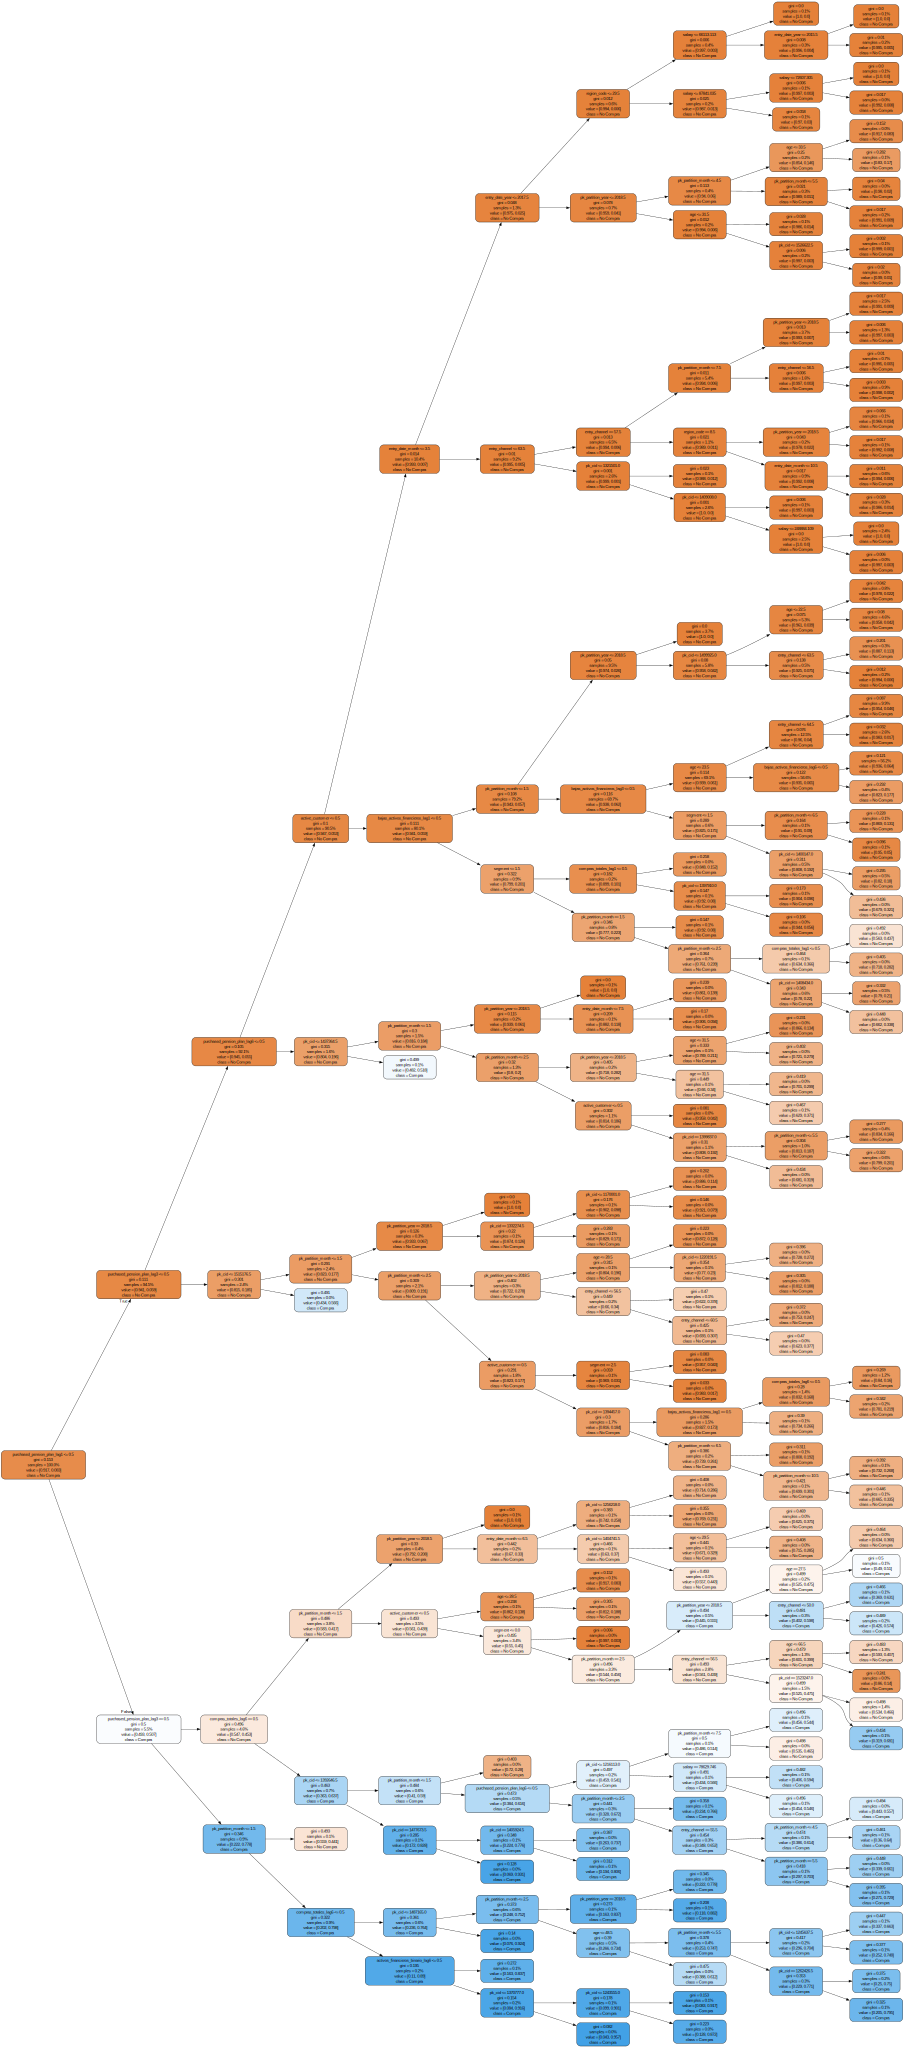

In [184]:
import graphviz
graphviz.Source(dot_data)

#Feature Importance

In [185]:
features = X_train.columns.to_list()

In [186]:
features

['pk_cid',
 'entry_channel',
 'active_customer',
 'segment',
 'country_id',
 'region_code',
 'gender',
 'age',
 'salary',
 'compras_totales_lag1',
 'compras_totales_lag3',
 'compras_totales_lag6',
 'activos_financieros_binario_lag1',
 'activos_financieros_binario_lag3',
 'activos_financieros_binario_lag6',
 'bajas_activos_financieros_lag1',
 'bajas_activos_financieros_lag3',
 'bajas_activos_financieros_lag6',
 'long_term_deposit_lag1',
 'long_term_deposit_lag3',
 'long_term_deposit_lag6',
 'purchased_pension_plan_lag1',
 'purchased_pension_plan_lag3',
 'purchased_pension_plan_lag6',
 'pk_partition_year',
 'pk_partition_month',
 'entry_date_year',
 'entry_date_month']

In [187]:
pd.Series(primer_modelo_DT.feature_importances_, index=features ).sort_values(ascending=False).head(30)

purchased_pension_plan_lag1         0.717942
purchased_pension_plan_lag3         0.082643
pk_partition_month                  0.044596
active_customer                     0.027036
purchased_pension_plan_lag6         0.023148
compras_totales_lag6                0.022958
pk_cid                              0.021193
bajas_activos_financieros_lag1      0.013501
pk_partition_year                   0.013496
age                                 0.008896
segment                             0.007794
entry_channel                       0.005900
bajas_activos_financieros_lag3      0.005475
bajas_activos_financieros_lag6      0.003566
entry_date_month                    0.000789
compras_totales_lag1                0.000493
entry_date_year                     0.000259
activos_financieros_binario_lag6    0.000217
salary                              0.000070
region_code                         0.000029
compras_totales_lag3                0.000000
gender                              0.000000
country_id

In [188]:
#Evaluacion

y_test_pred = pd.DataFrame(primer_modelo_DT.predict(X_test), index = y_test.index, columns = ['Purchase_Prediction'])

In [189]:
results_df = y_test.join(y_test_pred, how = 'inner')

In [190]:
results_df.head(10)

,activos_financieros_binario,Purchase_Prediction
921830,1,0
195736,0,0
176410,0,0
3980035,0,0
3558877,0,0
4538760,0,0
17219,0,0
4074660,0,0
2386020,0,0
430848,0,0


In [191]:
results_df['Sucess']=(results_df['activos_financieros_binario']==results_df['Purchase_Prediction']).astype(int)

In [192]:
results_df.head(10)

,activos_financieros_binario,Purchase_Prediction,Sucess
921830,1,0,0
195736,0,0,1
176410,0,0,1
3980035,0,0,1
3558877,0,0,1
4538760,0,0,1
17219,0,0,1
4074660,0,0,1
2386020,0,0,1
430848,0,0,1


In [193]:
results_df['Sucess'].mean()


0.9246672304321215

In [194]:
primer_modelo_DT.score(X_test,y_test)

0.9246672304321215

### Metodos de Evaluacion

#### CONFUSSION MATRIX

In [195]:
#CONFUSSION MATRIX
confusion_matrix=pd.crosstab(results_df['activos_financieros_binario'],results_df['Purchase_Prediction'])

In [196]:
confusion_matrix


Purchase_Prediction,0,1
activos_financieros_binario,,
0,194795,1424
1,14700,3118


In [197]:
#Almacenamos en variables en prevision del feature engineering
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [198]:
print(f"TP = {TP}")
print(f"TN = {TN}")
print(f"FP = {FP}")
print(f"FN = {FN}")

TP = 3118
TN = 194795
FP = 1424
FN = 14700


In [199]:
round(TP/X_test.shape[0]*100,2)

1.46

In [200]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.9246672304321215

#### Prediccion en forma probabilistica

In [201]:
#Prediccion en forma probabilistica

#En resumen, este código crea un DataFrame y_score que contiene las probabilidades predichas por el modelo modelo_final de que cada observación en X_test pertenezca a la clase 1.
#Estas probabilidades se almacenan en una columna llamada "Purchase_Score".
y_score=pd.DataFrame(primer_modelo_DT.predict_proba(X_test)[:,1],index=y_test.index,columns=['Purchase_Score'])



In [202]:
results_df=results_df.join(y_score)


In [203]:
results_df


,activos_financieros_binario,Purchase_Prediction,Sucess,Purchase_Score
921830,1,0,0,0.465911
195736,0,0,1,0.064481
176410,0,0,1,0.064481
3980035,0,0,1,0.016504
3558877,0,0,1,0.002802
...,...,...,...,...
4257931,0,0,1,0.000191
3975482,0,1,0,0.728843
4549299,0,0,1,0.016504
4466697,0,0,1,0.016504


In [204]:
 #Probaremos con un threshold de 0.3 para ver la variacion de los valores
results_df['Purchase_Prediction03']= (results_df['Purchase_Score'] >= 0.3).astype(int)

In [205]:
results_df['Success03'] = (results_df[TARGET_GENERAL] == results_df['Purchase_Prediction03']).astype(int)

In [206]:
results_df['Success03'].mean()

0.9185327770432214

#### F1 SCORE

In [207]:
#F1 SCORE
metrics.f1_score(y_test,y_test_pred)


0.2788908765652952

In [208]:
precision = precision_score(y_test, y_test_pred)

In [209]:
precision

0.686481726111845

In [210]:
recall = recall_score(y_test, y_test_pred)

In [211]:
recall

0.17499158154675049

#### ROC CURVE

In [212]:
## ROC CURVE
fpr,tpr,th=metrics.roc_curve(results_df['activos_financieros_binario'],results_df['Purchase_Score'])
#SUPER IMPORTANTE METER LA PROBABILIDAD ! !
#!! Si veo un triangulo le he pasado la prediccion y tengo q pasar la probabilaid


Text(0, 0.5, 'TPR')

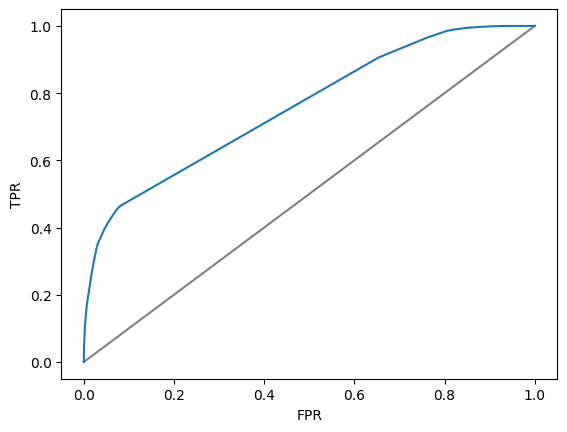

In [213]:
plt.plot([0,1],[0,1],color='grey')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [214]:
metrics.roc_auc_score(results_df['activos_financieros_binario'],results_df['Purchase_Score'])

0.7581733385216036

In [215]:
results_df

,activos_financieros_binario,Purchase_Prediction,Sucess,Purchase_Score,Purchase_Prediction03,Success03
921830,1,0,0,0.465911,1,1
195736,0,0,1,0.064481,0,1
176410,0,0,1,0.064481,0,1
3980035,0,0,1,0.016504,0,1
3558877,0,0,1,0.002802,0,1
...,...,...,...,...,...,...
4257931,0,0,1,0.000191,0,1
3975482,0,1,0,0.728843,1,0
4549299,0,0,1,0.016504,0,1
4466697,0,0,1,0.016504,0,1


In [216]:
results_df.head()

,activos_financieros_binario,Purchase_Prediction,Sucess,Purchase_Score,Purchase_Prediction03,Success03
921830,1,0,0,0.465911,1,1
195736,0,0,1,0.064481,0,1
176410,0,0,1,0.064481,0,1
3980035,0,0,1,0.016504,0,1
3558877,0,0,1,0.002802,0,1


### Modelos Alternativos

#### RandomForest

In [217]:
segundo_modelo_RF=RandomForestClassifier(n_estimators=100,max_depth=9,min_samples_leaf=100)

In [218]:
segundo_modelo_RF.fit(X_train, y_train)

/tmp/ipykernel_26/1426326542.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  segundo_modelo_RF.fit(X_train, y_train)


RandomForestClassifier(max_depth=9, min_samples_leaf=100)

In [219]:
#Aplicando Random Forest.
segundo_modelo_RF.score(val_df_X, val_df_y)

0.9328207799266272

#### XGBoost

In [220]:
tercer_modelo_XGB = xgb.XGBClassifier(n_estimators = 100, max_depth = 9, random_state = 42)

In [221]:
tercer_modelo_XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [222]:
y_pred = tercer_modelo_XGB.predict(X_test)

In [223]:
accuracy = accuracy_score(y_test, y_pred)

In [224]:
accuracy

0.926596803356429

In [225]:
tercer_modelo_XGB.score(val_df_X, val_df_y)

0.9317224511979709

### Rebalanceo

In [226]:
df_dev_zero = dev_df[dev_df[TARGET_GENERAL] == 0]
df_dev_nonzero = dev_df[dev_df[TARGET_GENERAL] > 0]


In [227]:
df_dev_zero.info(verbose = False)


<class 'pandas.core.frame.DataFrame'>
Index: 980888 entries, 2 to 4822275
Columns: 29 entries, pk_cid to entry_date_month
dtypes: float64(16), int32(4), int64(9)
memory usage: 209.5 MB


In [228]:
df_dev_nonzero.info(verbose = False)



<class 'pandas.core.frame.DataFrame'>
Index: 89293 entries, 16 to 4818173
Columns: 29 entries, pk_cid to entry_date_month
dtypes: float64(16), int32(4), int64(9)
memory usage: 19.1 MB


In [229]:
n_zero = len(df_dev_nonzero)*3

In [230]:
n_zero

267879

In [231]:
n_zero + 79590

347469

In [232]:
df_dev_zero_sample = df_dev_zero.sample(n = n_zero, random_state = 42 )


In [233]:
df_dev_zero_sample.shape


(267879, 29)

In [234]:
df_dev_nonzero.shape


(89293, 29)

In [235]:
len(df_dev_nonzero) / len(df_dev_zero_sample)

0.3333333333333333

In [236]:
df_dev_sample = pd.concat([df_dev_zero_sample,df_dev_nonzero])


In [237]:
df_dev_sample_X = df_dev_sample.drop(TARGET_GENERAL, axis = 1)
df_dev_sample_y = df_dev_sample[[TARGET_GENERAL]]


In [238]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_dev_sample_X,
    df_dev_sample_y,
    random_state = 42,
    test_size = .3
)

In [239]:
X_train.shape


(250020, 28)

In [240]:
X_test.shape

(107152, 28)

In [241]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,250020.0,1.250917e+06,179252.233382,16203.00,1.134968e+06,1262811.00,1382747.00,1547456.00
entry_channel,250020.0,4.950235e+01,14.746559,0.00,4.500000e+01,57.00,60.00,68.00
active_customer,250020.0,9.096072e-01,0.286744,0.00,1.000000e+00,1.00,1.00,1.00
segment,250020.0,2.262787e+00,0.659558,-1.00,2.000000e+00,2.00,3.00,3.00
country_id,250020.0,9.993920e-01,0.024649,0.00,1.000000e+00,1.00,1.00,1.00
region_code,250020.0,2.643492e+01,13.042394,0.00,1.500000e+01,28.00,35.00,52.00
gender,250020.0,4.464683e-01,0.497127,0.00,0.000000e+00,0.00,1.00,1.00
age,250020.0,3.618775e+01,13.158154,16.00,2.600000e+01,34.00,43.00,102.00
salary,250020.0,1.120289e+05,171615.808379,5163.75,6.612113e+04,89656.98,126448.77,28894395.51
compras_totales_lag1,250020.0,2.172946e-01,0.412406,0.00,0.000000e+00,0.00,0.00,1.00


In [242]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,107152.0,1.251536e+06,178362.043811,16502.00,1135557.00,1263329.50,1383044.75,1547739.00
entry_channel,107152.0,4.947343e+01,14.798907,0.00,45.00,57.00,60.00,68.00
active_customer,107152.0,9.090544e-01,0.287533,0.00,1.00,1.00,1.00,1.00
segment,107152.0,2.264045e+00,0.660151,-1.00,2.00,2.00,3.00,3.00
country_id,107152.0,9.994027e-01,0.024432,0.00,1.00,1.00,1.00,1.00
region_code,107152.0,2.638637e+01,13.033699,0.00,15.00,28.00,35.00,52.00
gender,107152.0,4.449754e-01,0.496965,0.00,0.00,0.00,1.00,1.00
age,107152.0,3.617921e+01,13.159104,16.00,26.00,34.00,43.00,102.00
salary,107152.0,1.116606e+05,158975.379391,5163.75,66046.02,89409.51,126219.78,24253236.93
compras_totales_lag1,107152.0,2.141537e-01,0.410236,0.00,0.00,0.00,0.00,1.00


In [243]:
for i in range(1,20):
    model_overfit = DecisionTreeClassifier(max_depth = i, min_samples_leaf= 100)
    model_overfit.fit(X_train, y_train)
    acc_train = round(model_overfit.score(X_train, y_train),3) #accuracy en train
    acc_test = round(model_overfit.score(X_test, y_test),3) #accuracy en test
    print(f'Profundidad del arbol {i}: Train {acc_train} , Test {acc_test}, Overfit {round(acc_train - acc_test,3)}')

Profundidad del arbol 1: Train 0.811 , Test 0.812, Overfit -0.001
Profundidad del arbol 2: Train 0.811 , Test 0.812, Overfit -0.001
Profundidad del arbol 3: Train 0.811 , Test 0.812, Overfit -0.001
Profundidad del arbol 4: Train 0.814 , Test 0.814, Overfit 0.0
Profundidad del arbol 5: Train 0.814 , Test 0.815, Overfit -0.001
Profundidad del arbol 6: Train 0.816 , Test 0.816, Overfit 0.0
Profundidad del arbol 7: Train 0.817 , Test 0.817, Overfit 0.0
Profundidad del arbol 8: Train 0.818 , Test 0.818, Overfit 0.0
Profundidad del arbol 9: Train 0.818 , Test 0.818, Overfit 0.0
Profundidad del arbol 10: Train 0.818 , Test 0.817, Overfit 0.001
Profundidad del arbol 11: Train 0.819 , Test 0.818, Overfit 0.001
Profundidad del arbol 12: Train 0.819 , Test 0.818, Overfit 0.001
Profundidad del arbol 13: Train 0.82 , Test 0.818, Overfit 0.002
Profundidad del arbol 14: Train 0.82 , Test 0.818, Overfit 0.002
Profundidad del arbol 15: Train 0.821 , Test 0.818, Overfit 0.003
Profundidad del arbol 16: T

In [244]:
#Modelling

primer_modelo_RE_DT=DecisionTreeClassifier( max_depth=9, min_samples_leaf=350, random_state=42 )



In [245]:
primer_modelo_RE_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=350, random_state=42)

In [246]:
#funcion directa
primer_modelo_RE_DT.score(val_df_X, val_df_y)

0.9214864803659586

In [247]:
#Evaluacion

y_test_pred = pd.DataFrame(primer_modelo_RE_DT.predict(X_test), index = y_test.index, columns = ['Purchase_Prediction'])

In [248]:
results_df_2 = y_test.join(y_test_pred, how = 'inner')

In [249]:
results_df_2.head(10)

,activos_financieros_binario,Purchase_Prediction
2792505,0,0
3785711,0,0
1380171,1,0
2696775,0,0
3944958,1,1
3998106,0,0
4346395,0,1
592692,0,0
3106466,1,1
4544266,1,1


In [250]:
results_df_2['Sucess']=(results_df_2['activos_financieros_binario']==results_df_2['Purchase_Prediction']).astype(int)

In [251]:
results_df_2.head(10)

,activos_financieros_binario,Purchase_Prediction,Sucess
2792505,0,0,1
3785711,0,0,1
1380171,1,0,0
2696775,0,0,1
3944958,1,1,1
3998106,0,0,1
4346395,0,1,0
592692,0,0,1
3106466,1,1,1
4544266,1,1,1


In [252]:
results_df_2['Sucess'].mean()


0.8161863520979543

In [253]:
primer_modelo_RE_DT.score(X_test,y_test)

0.8161863520979543

### Metodos de Evaluacion

#### CONFUSSION MATRIX

In [254]:
#CONFUSSION MATRIX
confusion_matrix=pd.crosstab(results_df_2['activos_financieros_binario'],results_df_2['Purchase_Prediction'])

In [255]:
confusion_matrix


Purchase_Prediction,0,1
activos_financieros_binario,,
0,77300,3010
1,16686,10156


In [256]:
#Almacenamos en variables en prevision del feature engineering
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [257]:
print(f"TP = {TP}")
print(f"TN = {TN}")
print(f"FP = {FP}")
print(f"FN = {FN}")

TP = 10156
TN = 77300
FP = 3010
FN = 16686


In [258]:
round(TP/X_test.shape[0]*100,2)

9.48

In [259]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.8161863520979543

#### Prediccion en forma probabilistica

In [260]:
#Prediccion en forma probabilistica

#En resumen, este código crea un DataFrame y_score que contiene las probabilidades predichas por el modelo modelo_final de que cada observación en X_test pertenezca a la clase 1.
#Estas probabilidades se almacenan en una columna llamada "Purchase_Score".
y_score=pd.DataFrame(primer_modelo_RE_DT.predict_proba(X_test)[:,1],index=y_test.index,columns=['Purchase_Score'])



In [261]:
results_df_2=results_df_2.join(y_score)


In [262]:
results_df_2


,activos_financieros_binario,Purchase_Prediction,Sucess,Purchase_Score
2792505,0,0,1,0.201863
3785711,0,0,1,0.201863
1380171,1,0,0,0.201863
2696775,0,0,1,0.201863
3944958,1,1,1,0.513067
...,...,...,...,...
4373740,0,0,1,0.201863
232832,0,0,1,0.201863
1454349,1,1,1,0.856923
1165044,0,0,1,0.201863


#### F1 SCORE

In [263]:
#F1 SCORE
metrics.f1_score(y_test,y_test_pred)


0.5076984603079385

In [264]:
precision = precision_score(y_test, y_test_pred)

In [265]:
precision

0.771380829409084

In [266]:
recall = recall_score(y_test, y_test_pred)

In [267]:
recall

0.3783622680873258

#### ROC CURVE

In [268]:
## ROC CURVE
fpr,tpr,th=metrics.roc_curve(results_df_2['activos_financieros_binario'],results_df_2['Purchase_Score'])
#SUPER IMPORTANTE METER LA PROBABILIDAD ! !
#!! Si veo un triangulo le he pasado la prediccion y tengo q pasar la probabilaid


Text(0, 0.5, 'TPR')

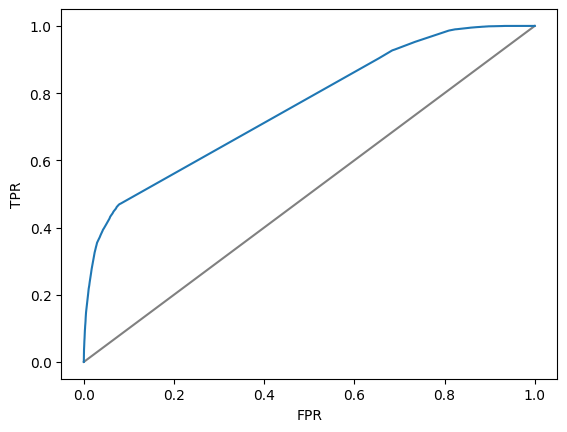

In [269]:
plt.plot([0,1],[0,1],color='grey')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [270]:
metrics.roc_auc_score(results_df_2['activos_financieros_binario'],results_df_2['Purchase_Score'])

0.7598692055098207

In [271]:
results_df_2

,activos_financieros_binario,Purchase_Prediction,Sucess,Purchase_Score
2792505,0,0,1,0.201863
3785711,0,0,1,0.201863
1380171,1,0,0,0.201863
2696775,0,0,1,0.201863
3944958,1,1,1,0.513067
...,...,...,...,...
4373740,0,0,1,0.201863
232832,0,0,1,0.201863
1454349,1,1,1,0.856923
1165044,0,0,1,0.201863


##SEGUNDO MODELO CON REBALANCEO - Modelo Elegido -

In [272]:
segundo_modelo_RF_RE=RandomForestClassifier(n_estimators=100,max_depth=9,min_samples_leaf=100)

In [273]:
segundo_modelo_RF_RE.fit(X_train, y_train)

/tmp/ipykernel_26/221816688.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  segundo_modelo_RF_RE.fit(X_train, y_train)


RandomForestClassifier(max_depth=9, min_samples_leaf=100)

In [274]:
#Aplicando Random Forest mejoramos nuestros valores obtenidos en nuestro modelo procesado con Decision Tree.
segundo_modelo_RF_RE.score(val_df_X, val_df_y)

0.9265252049458762

In [275]:
y_test_pred = pd.DataFrame(segundo_modelo_RF_RE.predict(X_test), index = y_test.index, columns = ['Purchase_Prediction'])

In [276]:
results_df_3 = y_test.join(y_test_pred, how = 'inner')

In [277]:
results_df_3.head(10)

,activos_financieros_binario,Purchase_Prediction
2792505,0,0
3785711,0,0
1380171,1,0
2696775,0,0
3944958,1,0
3998106,0,0
4346395,0,1
592692,0,0
3106466,1,0
4544266,1,1


In [278]:
results_df_3['Sucess']=(results_df_3['activos_financieros_binario']==results_df_3['Purchase_Prediction']).astype(int)

In [279]:
results_df_3.head()

,activos_financieros_binario,Purchase_Prediction,Sucess
2792505,0,0,1
3785711,0,0,1
1380171,1,0,0
2696775,0,0,1
3944958,1,0,0


In [280]:
results_df_3['Sucess'].mean()

0.8162143497088249

In [281]:
segundo_modelo_RF_RE.score(X_test,y_test)

0.8162143497088249

#### CONFUSSION MATRIX

In [282]:
#CONFUSSION MATRIX
confusion_matrix=pd.crosstab(results_df_3['activos_financieros_binario'],results_df_3['Purchase_Prediction'])

In [283]:
confusion_matrix


Purchase_Prediction,0,1
activos_financieros_binario,,
0,77909,2401
1,17292,9550


In [284]:
#Almacenamos en variables en prevision del feature engineering
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [285]:
print(f"TP = {TP}")
print(f"TN = {TN}")
print(f"FP = {FP}")
print(f"FN = {FN}")

TP = 9550
TN = 77909
FP = 2401
FN = 17292


In [286]:
round(TP/X_test.shape[0]*100,2)

8.91

In [287]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.8162143497088249

In [288]:
#Prediccion en forma probabilistica

#En resumen, este código crea un DataFrame y_score que contiene las probabilidades predichas por el modelo modelo_final de que cada observación en X_test pertenezca a la clase 1.
#Estas probabilidades se almacenan en una columna llamada "Purchase_Score".
y_score=pd.DataFrame(segundo_modelo_RF_RE.predict_proba(X_test)[:,1],index=y_test.index,columns=['Purchase_Score'])


In [289]:
y_score

,Purchase_Score
2792505,0.188680
3785711,0.189321
1380171,0.194381
2696775,0.187056
3944958,0.397681
...,...
4373740,0.225967
232832,0.194246
1454349,0.845925
1165044,0.187269


In [290]:
results_df_3=results_df_3.join(y_score)


In [291]:
results_df_3


,activos_financieros_binario,Purchase_Prediction,Sucess,Purchase_Score
2792505,0,0,1,0.188680
3785711,0,0,1,0.189321
1380171,1,0,0,0.194381
2696775,0,0,1,0.187056
3944958,1,0,0,0.397681
...,...,...,...,...
4373740,0,0,1,0.225967
232832,0,0,1,0.194246
1454349,1,1,1,0.845925
1165044,0,0,1,0.187269


#### F1 SCORE

In [292]:
#F1 SCORE
metrics.f1_score(y_test,y_test_pred)


0.4923568685072049

In [293]:
precision = precision_score(y_test, y_test_pred)

In [294]:
precision

0.7990963099322232

In [295]:
recall = recall_score(y_test, y_test_pred)

In [296]:
recall

0.35578570896356454

In [297]:
## ROC CURVE
fpr,tpr,th=metrics.roc_curve(results_df_3['activos_financieros_binario'],results_df_3['Purchase_Score'])



Text(0, 0.5, 'TPR')

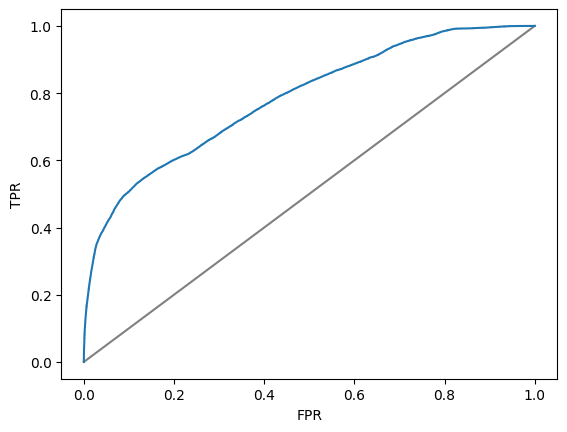

In [298]:
plt.plot([0,1],[0,1],color='grey')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [299]:
metrics.roc_auc_score(results_df_3['activos_financieros_binario'],results_df_3['Purchase_Score'])

0.7835130510171676

In [300]:
results_df_3

,activos_financieros_binario,Purchase_Prediction,Sucess,Purchase_Score
2792505,0,0,1,0.188680
3785711,0,0,1,0.189321
1380171,1,0,0,0.194381
2696775,0,0,1,0.187056
3944958,1,0,0,0.397681
...,...,...,...,...
4373740,0,0,1,0.225967
232832,0,0,1,0.194246
1454349,1,1,1,0.845925
1165044,0,0,1,0.187269


In [301]:
#### XGBoost, aplicamos este modelo, pero en la conclusion final no sera el modelo que mejores resultados obtiene.

In [302]:
tercer_modelo_XGB_RE = xgb.XGBClassifier(n_estimators = 100, max_depth = 9, random_state = 42)

In [303]:
tercer_modelo_XGB_RE.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [304]:
y_pred = tercer_modelo_XGB_RE.predict(X_test)

In [305]:
accuracy = accuracy_score(y_test, y_pred)

In [306]:
accuracy

0.8238763625503956

In [307]:
tercer_modelo_XGB_RE.score(val_df_X, val_df_y)

0.9166402463879705

#Analisis de la variable objetivo utilizando el Modelo 2 /Random Forest/ REBALANCEADO:

In [308]:
df_analisis1=df_cust_demo3.copy()

In [309]:
df_analisis1.set_index('pk_cid',inplace=True)

In [310]:
df_analisis1 = df_analisis1[(df_analisis1['pk_partition_year'] == 2019) &
                            (df_analisis1['pk_partition_month'] == 5)]

# Seleccionando solamente la columna 'purchased_pension_plan_binario'
df_analisis1 = df_analisis1[['activos_financieros_binario']]
df_analisis1

,activos_financieros_binario
pk_cid,
16203,0
16502,0
17457,0
17970,0
18146,0
...,...
1548197,1
1548197,1
1548201,0


### Conclusion Probabilidad final de compra de producto

In [311]:
y_test_predJUNIO = pd.DataFrame(segundo_modelo_RF_RE.predict(val_df_X), index = val_df_y.index, columns = ['Purchase_Prediction'])


In [312]:
y_test_predJUNIO


,Purchase_Prediction
1,0
10,0
15,0
49,0
78,0
...,...
4822468,1
4822469,1
4822470,0
4822471,0


In [313]:
y_test_predJUNIO.value_counts()


Purchase_Prediction
0                      82832
1                       5484
Name: count, dtype: int64

In [314]:
results_df_3JUNIO = val_df_y.join(y_test_predJUNIO, how = 'inner')


In [315]:
results_df_3JUNIO.head(10)


,activos_financieros_binario,Purchase_Prediction
1,0,0
10,0,0
15,0,0
49,0,0
78,0,0
104,0,0
139,0,0
162,0,0
219,0,0
244,0,0


In [316]:
results_df_3JUNIO.sum()


activos_financieros_binario    6681
Purchase_Prediction            5484
dtype: int64

In [317]:
results_df_3JUNIO['Sucess']=(results_df_3JUNIO['activos_financieros_binario']==results_df_3JUNIO['Purchase_Prediction']).astype(int)


In [318]:
results_df_3JUNIO.head()


,activos_financieros_binario,Purchase_Prediction,Sucess
1,0,0,1
10,0,0,1
15,0,0,1
49,0,0,1
78,0,0,1


In [319]:
results_df_3JUNIO['Sucess'].mean()


0.9265252049458762

In [320]:
segundo_modelo_RF_RE.score(val_df_X,val_df_y)

0.9265252049458762

### Conclusion Prediccion Probabilista de compra del producto (Pension Plan)

In [321]:
y_scoreJUNIO=pd.DataFrame(segundo_modelo_RF_RE.predict_proba(val_df_X)[:,1],index=val_df_y.index,columns=['Purchase_Score'])


In [322]:
y_scoreJUNIO


,Purchase_Score
1,0.191498
10,0.207152
15,0.183062
49,0.184817
78,0.200124
...,...
4822468,0.759075
4822469,0.952955
4822470,0.084936
4822471,0.213514


In [323]:
results_df_3JUNIO


,activos_financieros_binario,Purchase_Prediction,Sucess
1,0,0,1
10,0,0,1
15,0,0,1
49,0,0,1
78,0,0,1
...,...,...,...
4822468,1,1,1
4822469,1,1,1
4822470,0,0,1
4822471,0,0,1


In [324]:
results_df_3JUNIO=results_df_3JUNIO.join(y_scoreJUNIO)


In [325]:
results_df_3JUNIO


,activos_financieros_binario,Purchase_Prediction,Sucess,Purchase_Score
1,0,0,1,0.191498
10,0,0,1,0.207152
15,0,0,1,0.183062
49,0,0,1,0.184817
78,0,0,1,0.200124
...,...,...,...,...
4822468,1,1,1,0.759075
4822469,1,1,1,0.952955
4822470,0,0,1,0.084936
4822471,0,0,1,0.213514


In [326]:
 #Probaremos con un threshold de 0.5 para ver la variacion de los valores
results_df_3JUNIO['Purchase_Prediction05']= (results_df_3JUNIO['Purchase_Score'] >= 0.5).astype(int)


In [327]:
results_df_3JUNIO['Success05'] = (results_df_3JUNIO[TARGET_GENERAL] == results_df_3JUNIO['Purchase_Prediction05']).astype(int)


In [328]:
results_df_3JUNIO['Success05'].mean()

0.9265252049458762

### Dataframe de analisis de compradores

In [329]:
val_df_X_EstimacionCompras = val_df_X.copy()  # Copia el DataFrame original (solo incluido mayo)


In [330]:
val_df_X_EstimacionCompras.set_index('pk_cid', inplace=True)  # Establece la columna 'pk_cid' como el nuevo índice


In [331]:
val_df_X_EstimacionCompras


,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary,compras_totales_lag1,compras_totales_lag3,compras_totales_lag6,activos_financieros_binario_lag1,activos_financieros_binario_lag3,activos_financieros_binario_lag6,bajas_activos_financieros_lag1,bajas_activos_financieros_lag3,bajas_activos_financieros_lag6,long_term_deposit_lag1,long_term_deposit_lag3,long_term_deposit_lag6,purchased_pension_plan_lag1,purchased_pension_plan_lag3,purchased_pension_plan_lag6,pk_partition_year,pk_partition_month,entry_date_year,entry_date_month
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,
16203,17,1,1,1,8,0,70,126313.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2018,12
16502,62,1,2,1,28,1,58,135263.28,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2018,9
17457,17,1,2,1,28,1,54,102405.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2019,5,2017,9
17970,17,1,2,1,28,0,76,126718.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2015,4
18146,44,1,1,1,28,0,65,136820.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548197,61,1,2,1,29,0,40,88525.71,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2019,5,2019,4
1548197,61,1,2,1,29,0,40,88525.71,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2019,5,2019,4
1548201,61,0,2,1,28,1,36,110966.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2019,4


### Predict

In [332]:
y_test_pred_EstimacionCompras = pd.DataFrame(segundo_modelo_RF_RE.predict(val_df_X), index = val_df_X_EstimacionCompras.index, columns = ['Purchase_Prediction'])


In [333]:
y_test_pred_EstimacionCompras.value_counts()


Purchase_Prediction
0                      82832
1                       5484
Name: count, dtype: int64

### Predict Proba -- Probabilidad de compra

In [334]:
y_scoreJUNIO=pd.DataFrame(segundo_modelo_RF_RE.predict_proba(val_df_X)[:,1],index = val_df_X_EstimacionCompras.index,columns=['Purchase_Score'])

In [335]:
y_scoreJUNIO_sorted = y_scoreJUNIO.sort_values(by='Purchase_Score', ascending=False)

In [336]:
y_scoreJUNIO_sorted_ProbCompra=y_scoreJUNIO_sorted[y_scoreJUNIO_sorted['Purchase_Score']>=0.5]

In [337]:
y_scoreJUNIO_sorted_ProbCompra

,Purchase_Score
pk_cid,
1521713,0.976677
1435351,0.976293
1403296,0.976126
1403296,0.976126
1528911,0.975815
...,...
1052935,0.500194
650478,0.500187
1114268,0.500157


In [338]:
y_scoreJUNIO_sorted_ProbCompra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5484 entries, 1521713 to 1221419
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Purchase_Score  5484 non-null   float64
dtypes: float64(1)
memory usage: 85.7 KB


In [339]:
y_test_pred_EstimacionCompras.head()

,Purchase_Prediction
pk_cid,
16203,0
16502,0
17457,0
17970,0
18146,0


In [340]:
ComprasEstimadasJunio=y_test_pred_EstimacionCompras[y_test_pred_EstimacionCompras['Purchase_Prediction']>0]


In [341]:
ComprasEstimadasJunio

,Purchase_Prediction
pk_cid,
50006,1
62175,1
62870,1
74455,1
76927,1
...,...
1548186,1
1548186,1
1548197,1


In [342]:
## queremos que el index 'pk_cid' sea una columna
ComprasEstimadasJunio.reset_index(inplace=True)


In [343]:
## queremos que el index 'pk_cid' sea una columna
y_scoreJUNIO_sorted_ProbCompra.reset_index(inplace=True)

In [344]:
y_scoreJUNIO_sorted_ProbCompra

,pk_cid,Purchase_Score
0,1521713,0.976677
1,1435351,0.976293
2,1403296,0.976126
3,1403296,0.976126
4,1528911,0.975815
...,...,...
5479,1052935,0.500194
5480,650478,0.500187
5481,1114268,0.500157
5482,1307969,0.500086


In [345]:
ComprasEstimadasJunio.index.name = 'Index'

In [346]:
y_scoreJUNIO_sorted_ProbCompra.index.name = 'Index'

In [347]:
y_scoreJUNIO_sorted_ProbCompra

,pk_cid,Purchase_Score
Index,,
0,1521713,0.976677
1,1435351,0.976293
2,1403296,0.976126
3,1403296,0.976126
4,1528911,0.975815
...,...,...
5479,1052935,0.500194
5480,650478,0.500187
5481,1114268,0.500157


In [348]:
ComprasEstimadasJunio

,pk_cid,Purchase_Prediction
Index,,
0,50006,1
1,62175,1
2,62870,1
3,74455,1
4,76927,1
...,...,...
5479,1548186,1
5480,1548186,1
5481,1548197,1


In [349]:
#Filtraremos un dataset con los registros pertenecientes a Mayo
df_cust_demo_MAYO =  df_cust_demo3[( df_cust_demo3['pk_partition_year'] == 2019) & ( df_cust_demo3['pk_partition_month'] == 5)]


In [350]:
df_cust_demo_MAYO = df_cust_demo_MAYO.drop_duplicates(subset=['pk_cid'])

In [351]:
df_cust_demo_MAYO

,pk_cid,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary,activos_financieros_binario,compras_totales_lag1,compras_totales_lag3,compras_totales_lag6,activos_financieros_binario_lag1,activos_financieros_binario_lag3,activos_financieros_binario_lag6,bajas_activos_financieros_lag1,bajas_activos_financieros_lag3,bajas_activos_financieros_lag6,long_term_deposit_lag1,long_term_deposit_lag3,long_term_deposit_lag6,purchased_pension_plan_lag1,purchased_pension_plan_lag3,purchased_pension_plan_lag6,pk_partition_year,pk_partition_month,entry_date_year,entry_date_month
1,16203,17,1,1,1,8,0,70,126313.98,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2018,12
10,16502,62,1,2,1,28,1,58,135263.28,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2018,9
15,17457,17,1,2,1,28,1,54,102405.75,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2019,5,2017,9
49,17970,17,1,2,1,28,0,76,126718.74,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2015,4
78,18146,44,1,1,1,28,0,65,136820.79,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4822464,1548196,61,1,2,1,12,1,32,61087.11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2019,4
4822466,1548197,61,1,2,1,29,0,40,88525.71,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2019,4
4822470,1548201,61,0,2,1,28,1,36,110966.67,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2019,4
4822471,1548202,61,1,2,1,28,0,22,144820.14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2019,4


In [352]:
# Combina los DataFrames basados en 'pk_cid'
ComprasEstimadasJunio = ComprasEstimadasJunio.merge(df_cust_demo_MAYO[['pk_cid', 'entry_channel', 'active_customer', 'segment', 'country_id', 'region_code', 'gender', 'age', 'salary', 'entry_date_year', 'entry_date_month']], on='pk_cid', how='left')

In [353]:
# Combina los DataFrames basados en 'pk_cid' para tener csv final de probabiliad de compra %
y_scoreJUNIO_sorted_ProbCompra = y_scoreJUNIO_sorted_ProbCompra.merge(df_cust_demo_MAYO[['pk_cid', 'entry_channel', 'active_customer', 'segment', 'country_id', 'region_code', 'gender', 'age', 'salary', 'entry_date_year', 'entry_date_month']], on='pk_cid', how='left')

In [354]:
ComprasEstimadasJunio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5484 entries, 0 to 5483
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_cid               5484 non-null   int64  
 1   Purchase_Prediction  5484 non-null   int64  
 2   entry_channel        5484 non-null   int64  
 3   active_customer      5484 non-null   int64  
 4   segment              5484 non-null   int64  
 5   country_id           5484 non-null   int64  
 6   region_code          5484 non-null   int64  
 7   gender               5484 non-null   int64  
 8   age                  5484 non-null   int64  
 9   salary               5484 non-null   float64
 10  entry_date_year      5484 non-null   int32  
 11  entry_date_month     5484 non-null   int32  
dtypes: float64(1), int32(2), int64(9)
memory usage: 471.4 KB


In [355]:
y_scoreJUNIO_sorted_ProbCompra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5484 entries, 0 to 5483
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pk_cid            5484 non-null   int64  
 1   Purchase_Score    5484 non-null   float64
 2   entry_channel     5484 non-null   int64  
 3   active_customer   5484 non-null   int64  
 4   segment           5484 non-null   int64  
 5   country_id        5484 non-null   int64  
 6   region_code       5484 non-null   int64  
 7   gender            5484 non-null   int64  
 8   age               5484 non-null   int64  
 9   salary            5484 non-null   float64
 10  entry_date_year   5484 non-null   int32  
 11  entry_date_month  5484 non-null   int32  
dtypes: float64(2), int32(2), int64(8)
memory usage: 471.4 KB


In [356]:
df_cust_demo_MAYO[df_cust_demo_MAYO['pk_cid']==1465864]

,pk_cid,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary,activos_financieros_binario,compras_totales_lag1,compras_totales_lag3,compras_totales_lag6,activos_financieros_binario_lag1,activos_financieros_binario_lag3,activos_financieros_binario_lag6,bajas_activos_financieros_lag1,bajas_activos_financieros_lag3,bajas_activos_financieros_lag6,long_term_deposit_lag1,long_term_deposit_lag3,long_term_deposit_lag6,purchased_pension_plan_lag1,purchased_pension_plan_lag3,purchased_pension_plan_lag6,pk_partition_year,pk_partition_month,entry_date_year,entry_date_month
4551383,1465864,61,1,2,1,3,0,31,64380.3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,2018,9


In [357]:
ComprasEstimadasJunio.head(30)

,pk_cid,Purchase_Prediction,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary,entry_date_year,entry_date_month
0,50006,1,62,1,2,1,36,1,85,79449.18,2019,1
1,62175,1,17,1,2,1,8,1,47,162620.43,2015,6
2,62870,1,61,1,2,1,41,1,43,79345.56,2018,10
3,74455,1,17,1,2,1,28,1,48,111238.47,2016,1
4,76927,1,62,1,2,1,8,1,75,107702.55,2019,3
5,76927,1,62,1,2,1,8,1,75,107702.55,2019,3
6,105831,1,17,1,2,1,28,0,70,113560.89,2015,5
7,120000,1,2,1,2,1,35,0,48,106687.74,2017,6
8,120751,1,17,1,2,1,28,1,66,188533.59,2016,1
9,229549,1,17,1,2,1,42,0,43,207624.72,2017,7


In [358]:
y_scoreJUNIO_sorted_ProbCompra.head(20)

,pk_cid,Purchase_Score,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary,entry_date_year,entry_date_month
0,1521713,0.976677,61,1,2,1,33,1,40,71857.14,2019,1
1,1435351,0.976293,63,1,2,1,28,0,40,77554.32,2018,8
2,1403296,0.976126,62,1,2,1,3,0,34,77732.58,2018,6
3,1403296,0.976126,62,1,2,1,3,0,34,77732.58,2018,6
4,1528911,0.975815,61,1,2,1,11,1,36,75936.87,2019,2
5,1402776,0.975524,62,1,2,1,28,0,42,97619.76,2018,6
6,1527545,0.974483,62,1,2,1,40,0,44,130263.33,2019,1
7,1396179,0.974285,59,1,2,1,35,0,33,73595.31,2018,5
8,1395577,0.974163,67,1,3,1,26,0,29,84602.61,2018,5
9,1528328,0.972531,62,1,2,1,28,1,33,112672.65,2019,1


In [359]:
ComprasEstimadasJunio['Purchase_Prediction'].value_counts()

Purchase_Prediction
1    5484
Name: count, dtype: int64

### Percentiles Prediccion de Compra Dataset

In [360]:

percentile_75 = y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'].quantile(0.75)

In [361]:
percentile_75

0.7890829706162905

In [362]:
above_percentile_75 = y_scoreJUNIO_sorted_ProbCompra[y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'] > percentile_75]

In [363]:
above_percentile_75.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1371 entries, 0 to 1370
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pk_cid            1371 non-null   int64  
 1   Purchase_Score    1371 non-null   float64
 2   entry_channel     1371 non-null   int64  
 3   active_customer   1371 non-null   int64  
 4   segment           1371 non-null   int64  
 5   country_id        1371 non-null   int64  
 6   region_code       1371 non-null   int64  
 7   gender            1371 non-null   int64  
 8   age               1371 non-null   int64  
 9   salary            1371 non-null   float64
 10  entry_date_year   1371 non-null   int32  
 11  entry_date_month  1371 non-null   int32  
dtypes: float64(2), int32(2), int64(8)
memory usage: 128.5 KB


In [364]:
above_percentile_75.head(20)

,pk_cid,Purchase_Score,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary,entry_date_year,entry_date_month
0,1521713,0.976677,61,1,2,1,33,1,40,71857.14,2019,1
1,1435351,0.976293,63,1,2,1,28,0,40,77554.32,2018,8
2,1403296,0.976126,62,1,2,1,3,0,34,77732.58,2018,6
3,1403296,0.976126,62,1,2,1,3,0,34,77732.58,2018,6
4,1528911,0.975815,61,1,2,1,11,1,36,75936.87,2019,2
5,1402776,0.975524,62,1,2,1,28,0,42,97619.76,2018,6
6,1527545,0.974483,62,1,2,1,40,0,44,130263.33,2019,1
7,1396179,0.974285,59,1,2,1,35,0,33,73595.31,2018,5
8,1395577,0.974163,67,1,3,1,26,0,29,84602.61,2018,5
9,1528328,0.972531,62,1,2,1,28,1,33,112672.65,2019,1


In [365]:
y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'].describe()

count    5484.000000
mean        0.752602
std         0.103899
min         0.500066
25%         0.719579
50%         0.741053
75%         0.789083
max         0.976677
Name: Purchase_Score, dtype: float64

In [366]:

percentile_50 = y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'].quantile(0.50)

In [367]:
percentile_50

0.7410530778480964

In [368]:
above_percentile_50 = y_scoreJUNIO_sorted_ProbCompra[y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'] > percentile_50]

In [369]:
above_percentile_50.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2742 entries, 0 to 2741
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pk_cid            2742 non-null   int64  
 1   Purchase_Score    2742 non-null   float64
 2   entry_channel     2742 non-null   int64  
 3   active_customer   2742 non-null   int64  
 4   segment           2742 non-null   int64  
 5   country_id        2742 non-null   int64  
 6   region_code       2742 non-null   int64  
 7   gender            2742 non-null   int64  
 8   age               2742 non-null   int64  
 9   salary            2742 non-null   float64
 10  entry_date_year   2742 non-null   int32  
 11  entry_date_month  2742 non-null   int32  
dtypes: float64(2), int32(2), int64(8)
memory usage: 257.1 KB


In [370]:
above_percentile_50.head(20)

,pk_cid,Purchase_Score,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary,entry_date_year,entry_date_month
0,1521713,0.976677,61,1,2,1,33,1,40,71857.14,2019,1
1,1435351,0.976293,63,1,2,1,28,0,40,77554.32,2018,8
2,1403296,0.976126,62,1,2,1,3,0,34,77732.58,2018,6
3,1403296,0.976126,62,1,2,1,3,0,34,77732.58,2018,6
4,1528911,0.975815,61,1,2,1,11,1,36,75936.87,2019,2
5,1402776,0.975524,62,1,2,1,28,0,42,97619.76,2018,6
6,1527545,0.974483,62,1,2,1,40,0,44,130263.33,2019,1
7,1396179,0.974285,59,1,2,1,35,0,33,73595.31,2018,5
8,1395577,0.974163,67,1,3,1,26,0,29,84602.61,2018,5
9,1528328,0.972531,62,1,2,1,28,1,33,112672.65,2019,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


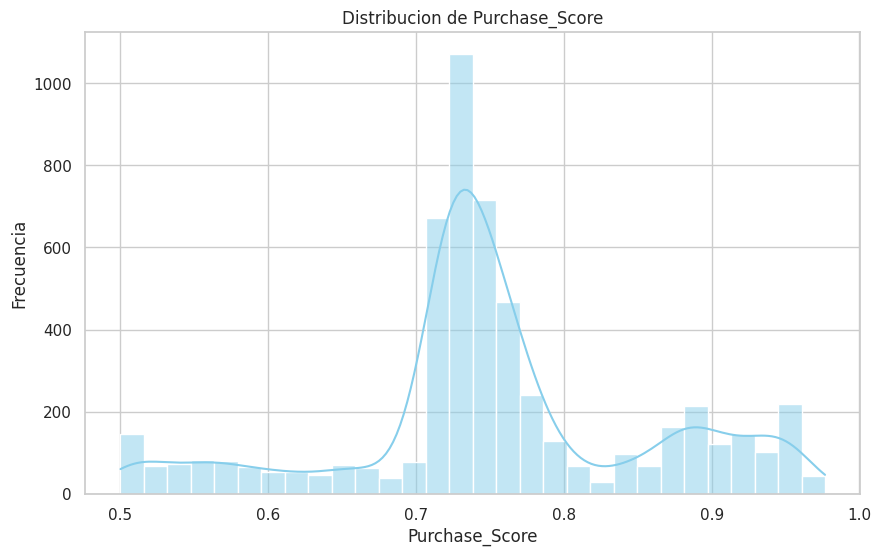

In [371]:
sns.set_theme(style="whitegrid")
# 1. Distribution of Purchase_Score
plt.figure(figsize=(10, 6))
sns.histplot(y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'], bins=30, kde=True, color='skyblue')
plt.title('Distribucion de Purchase_Score')
plt.xlabel('Purchase_Score')
plt.ylabel('Frecuencia')
plt.show()

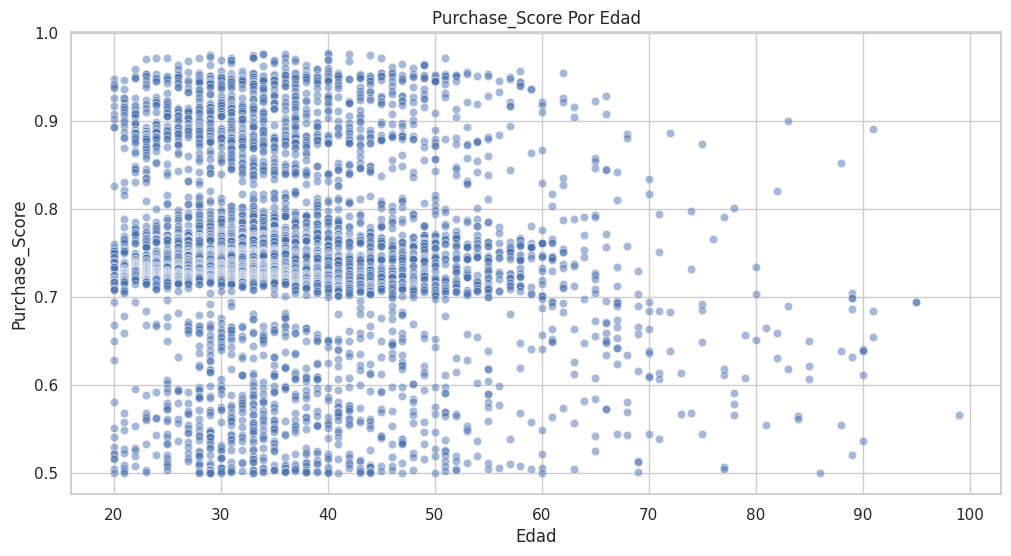

In [372]:
# 3. Purchase_Score Por Edad
plt.figure(figsize=(12, 6))
sns.scatterplot(x='age', y='Purchase_Score', data=y_scoreJUNIO_sorted_ProbCompra, alpha=0.5)
plt.title('Purchase_Score Por Edad')
plt.xlabel('Edad')
plt.ylabel('Purchase_Score')
plt.show()

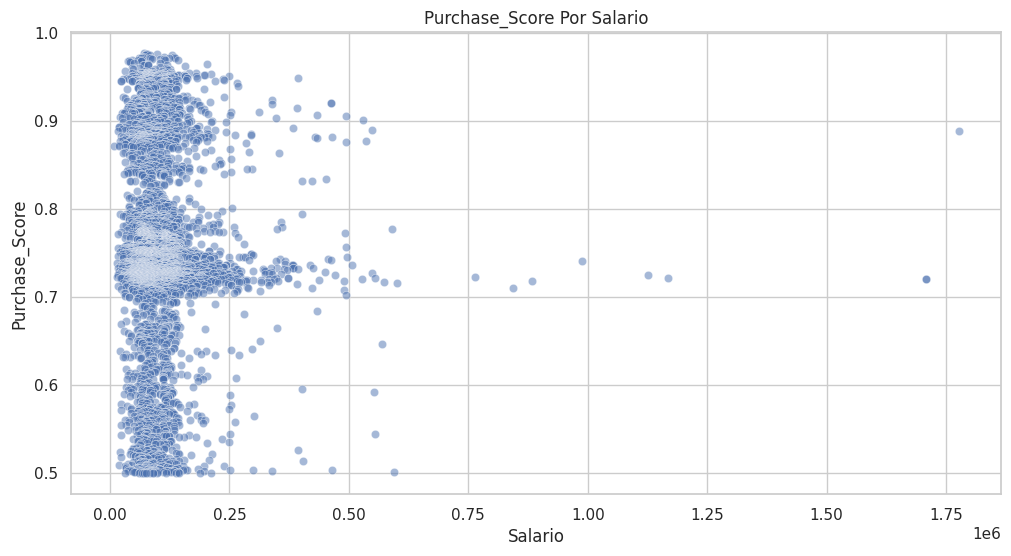

In [373]:
# 4. Purchase_Score Por Salario
plt.figure(figsize=(12, 6))
sns.scatterplot(x='salary', y='Purchase_Score', data=y_scoreJUNIO_sorted_ProbCompra, alpha=0.5)
plt.title('Purchase_Score Por Salario')
plt.xlabel('Salario')
plt.ylabel('Purchase_Score')
plt.show()

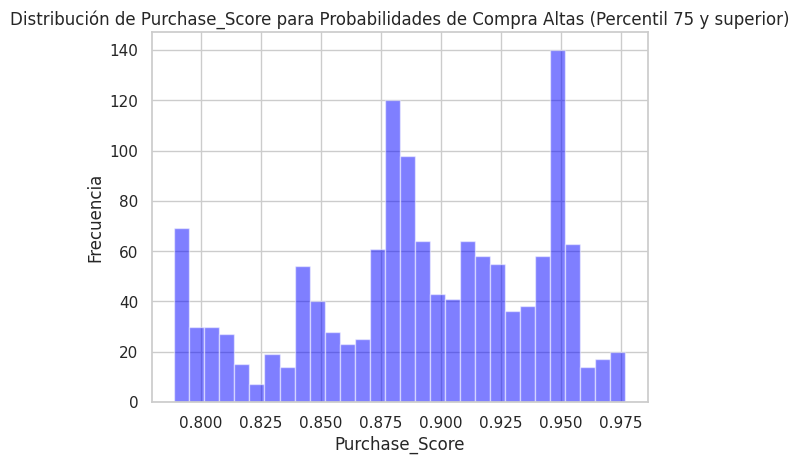

In [374]:
# Calcula el percentil 75
percentile_75 = y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'].quantile(0.75)
# Filtra los valores por encima del percentil 75
high_probability_purchase = y_scoreJUNIO_sorted_ProbCompra[y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'] > percentile_75]
# Crea un histograma de los valores de 'Purchase_Score' por encima del percentil 75
plt.hist(high_probability_purchase['Purchase_Score'], bins=30, alpha=0.5, color='blue')
plt.xlabel('Purchase_Score')
plt.ylabel('Frecuencia')
plt.title('Distribución de Purchase_Score para Probabilidades de Compra Altas (Percentil 75 y superior)')
# Muestra el gráfico
plt.show()

/tmp/ipykernel_26/2535799441.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'], shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


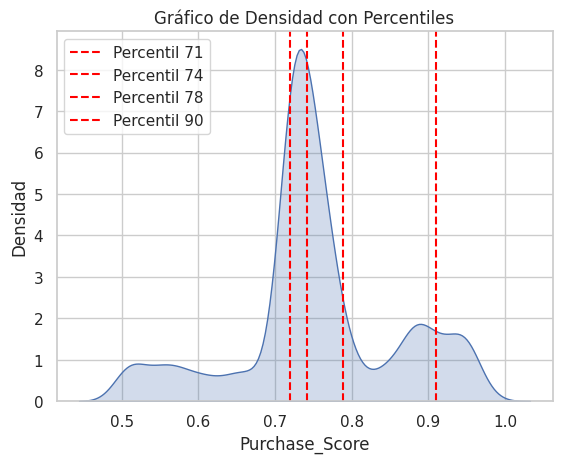

In [375]:
percentiles_to_plot = [0.25, 0.50, 0.75, 0.90]
percentile_data = y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'].quantile(percentiles_to_plot)
sns.kdeplot(data=y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'], shade=True)
for percentile in percentile_data:
    plt.axvline(x=percentile, color='red', linestyle='--', label=f'Percentil {int(percentile * 100)}')
plt.xlabel('Purchase_Score')
plt.ylabel('Densidad')
plt.title('Gráfico de Densidad con Percentiles')
plt.legend()
plt.show()

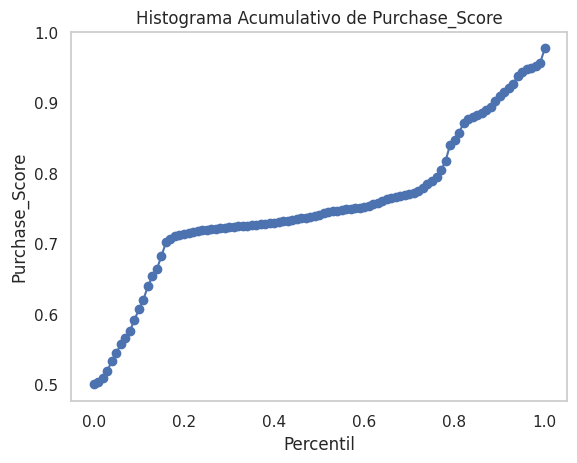

In [376]:
percentiles_to_plot = np.arange(0, 1.01, 0.01)
percentile_values = y_scoreJUNIO_sorted_ProbCompra['Purchase_Score'].quantile(percentiles_to_plot)
plt.plot(percentiles_to_plot, percentile_values, marker='o')
plt.xlabel('Percentil')
plt.ylabel('Purchase_Score')
plt.title('Histograma Acumulativo de Purchase_Score')
plt.grid()
plt.show()

### Analisis percentiles

In [377]:
#Vemos que en el percentil 50 englobaria a mas clientes y con los graficos se nota la tendencia en la probabilidad de compra.

In [378]:
#above_percentile_50.to_csv('/content/drive/MyDrive/TFM/PowerBI/csv/Activos_Financieros/Percentil_50_ActivosFinancieros_V2.csv', index=False)

In [379]:
# Exportamos .csv para analizar el PowerBI y mostrar conclusiones finales respecto a % Probabilidades de compra ordenados
#y_scoreJUNIO_sorted_ProbCompra.to_csv('/content/drive/MyDrive/TFM/PowerBI/csv/Activos_Financieros/ProbabilidadCompra_ActivosFinancieros_V2.csv', index=False)

In [380]:
# Exportamos .csv para analizar el PowerBI y mostrar conclusiones finales.
#ComprasEstimadasJunio.to_csv('/content/drive/MyDrive/TFM/PowerBI/csv/Activos_Financieros/ComprasEstimadasJunioAnalisis_ActivosFinancieros_V2.csv', index=False)

###PICKLE FINAL Y EXPORTACION DEL ARCHIVO

In [381]:
#df_cust_demo3.to_pickle("/content/drive/MyDrive/TFM/pickle's/Activos_Financieros/pickle3_Activos_Financieros.pkl")